# RSSI Localization Pipeline
This notebook documents the full neural-network + local KNN pipeline used to locate the WiFi probe on the board. Each cell explains how a raw RSSI vector is transformed into an embedding, how the L-KNN votes, and which diagnostics you can read to understand the prediction.

## Prerequisites
- Run `PYTHONPATH=src python -m localization.pipeline ...` at least once to produce `reports/localizer.joblib` and the generated metrics (confusion matrix, JSON report, etc.).
- Work inside the same Python environment (`.venv`) so that the imported modules and dependencies match those used during training.
- Keep the measurement folders `ddeuxmetres/` and `dquatremetres/` available since this notebook loads them directly.
- Glossary of terms used below:
  - **RSSI (Received Signal Strength Indicator)**: WiFi power in dBm reported by the router for each antenna.
  - **Embedding**: compact vector representation produced by the MLP to summarize the RSSI pattern of a cell.
  - **Local KNN (L-KNN)**: distance-weighted K-nearest neighbors operating in the embedding space to predict the cell ID.

## Rappels sur les entrées et la séparation des données
- Les 5 features d'entrée sont strictement RSSI (`Signal`, `Noise`, `signal_A1`, `signal_A2`, `signal_A3`).
- La distance routeur reste une métadonnée pour l'analyse mais **n'est pas injectée** dans le modèle.
- Le pipeline CLI réalise un split stratifié 80/20 sur les index sans chevauchement : les 20% de test ne sont jamais vus pendant l'entraînement.
- Les métriques et artefacts (`latest_metrics.json`, matrices de confusion, etc.) reflètent uniquement ce split de validation.


## Phase 1 - Prepare the tooling

In [61]:

# Import required modules: filesystem helpers, plotting, math utilities, and our local code.
from pathlib import Path
import sys

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, Markdown, Image
from sklearn.decomposition import PCA

plt.style.use('seaborn-v0_8')  # readable styling for plots

# Define important paths: project root, measurement folders, trained model, and the cell layout image.
PROJECT_ROOT = Path('..').resolve()
DATA_FOLDERS = [
    PROJECT_ROOT / 'data' / 'D005' / 'ddeuxmetres',
    PROJECT_ROOT / 'data' / 'D005' / 'dquatremetres',
    PROJECT_ROOT / 'data' / 'E101' / 'dtroismetres',
    PROJECT_ROOT / 'data' / 'E101' / 'dcinqmetres',
]
MODEL_PATH = PROJECT_ROOT / 'reports' / 'localizer.joblib'
GRID_IMAGE_PATH = PROJECT_ROOT / 'gridcellrepresentation.png'

# Allow imports from the local `src/` directory.
sys.path.append(str(PROJECT_ROOT / 'src'))

from localization.data import CampaignSpec, load_measurements, DEFAULT_CELL_WIDTH_M, DEFAULT_CELL_HEIGHT_M
from localization.embedding_knn import EmbeddingKnnLocalizer, _apply_activation

FEATURE_COLUMNS = ["Signal", "Noise", "signal_A1", "signal_A2", "signal_A3"]

print(f"Project root: {PROJECT_ROOT}")
print(f"Expected model path: {MODEL_PATH}")

REPORTS_DIR = PROJECT_ROOT / "reports"
REPORTS_DIR.mkdir(exist_ok=True)


Project root: /home/test/Documents/projetretd
Expected model path: /home/test/Documents/projetretd/reports/localizer.joblib


We configure project paths, add `src/` to `sys.path`, and import the helper modules (`localization.data`, `localization.embedding_knn`). This also defines the RSSI feature list (`FEATURE_COLUMNS`).

## Phase 2 - Load and combine measurements

In [62]:

# Build the list of campaigns (2 m + 4 m) that are actually present on disk.
campaigns = [CampaignSpec(path) for path in DATA_FOLDERS if path.exists()]
if not campaigns:
    raise RuntimeError("No campaign found. Verify data/D005 and data/E101 folders (ddeuxmetres/dquatremetres/dtroismetres/dcinqmetres).")

# Merge every CSV into a single DataFrame while keeping grid/campaign metadata.
df = load_measurements(campaigns)
print(f"Loaded {len(df)} rows covering {df['grid_cell'].nunique()} cells.")
display(df.head())

# Quick lookup table to retrieve spatial info (grid indices, metric coordinates, campaign name).
cell_lookup = (
    df[["grid_cell", "grid_x", "grid_y", "coord_x_m", "coord_y_m", "campaign"]]
    .drop_duplicates("grid_cell")
    .set_index("grid_cell")
)
GRID_WIDTH_M = df["coord_x_m"].max() + DEFAULT_CELL_WIDTH_M / 2
GRID_HEIGHT_M = df["coord_y_m"].max() + DEFAULT_CELL_HEIGHT_M / 2


Loaded 5300 rows covering 72 cells.


,Signal,Noise,signal_A1,signal_A2,signal_A3,grid_x,grid_y,grid_cell,router_distance_m,campaign,coord_x_m,coord_y_m
0,-37,-95,-38,-43,-48,0,0,0_0,2.0,ddeuxmetres,0.125,0.15
1,-37,-95,-38,-43,-48,0,0,0_0,2.0,ddeuxmetres,0.125,0.15
2,-37,-95,-38,-43,-48,0,0,0_0,2.0,ddeuxmetres,0.125,0.15
3,-37,-95,-38,-43,-48,0,0,0_0,2.0,ddeuxmetres,0.125,0.15
4,-37,-95,-38,-43,-48,0,0,0_0,2.0,ddeuxmetres,0.125,0.15


The campaigns `ddeuxmetres` and `dquatremetres` are merged into a single DataFrame. Each row contains:
- the RSSI values (`Signal`, `Noise`, `signal_Ai`),
- the discrete grid indices (`grid_x`, `grid_y`) and the corresponding metric coordinates,
- the campaign label (router distance). The model only uses the RSSI-derived features; distance stays as metadata for analysis.
By centralizing everything, we can train/evaluate without any extra preprocessing outside Python.

### Looking at a raw CSV file

In [63]:
# Pick the first CSV available to illustrate the raw data structure generated by collect_wifi.sh.
example_csv = None
for folder in DATA_FOLDERS:
    if not folder.exists():
        continue
    candidates = sorted(folder.glob('*.csv'))
    if candidates:
        example_csv = candidates[0]
        break
if example_csv is None:
    raise FileNotFoundError("No CSV found in the campaign folders.")

print(f"Example raw file: {example_csv.relative_to(PROJECT_ROOT)}")
raw_example = pd.read_csv(example_csv)
display(raw_example.head())


Example raw file: data/D005/ddeuxmetres/0_0.csv


,Signal,Noise,signal_A1,signal_A2,signal_A3
0,-37,-95,-38,-43,-48
1,-37,-95,-38,-43,-48
2,-37,-95,-38,-43,-48
3,-37,-95,-38,-43,-48
4,-37,-95,-38,-43,-48


This preview of a raw CSV shows why `load_measurements` enriches the data: the files record only RSSI values. Grid metadata and router distance are injected in Python to make the dataset self-contained.

## Phase 3 - Load the trained model

In [64]:
# Load the trained model (MLP encoder + L-KNN).
if not MODEL_PATH.exists():
    raise FileNotFoundError("Trained model missing. Rerun localization.pipeline to generate reports/localizer.joblib.")

localizer: EmbeddingKnnLocalizer = joblib.load(MODEL_PATH)
print("MLP architecture:", localizer.encoder_.hidden_layer_sizes)
print("KNN parameters:", localizer.knn_.get_params())
print(f"Iterations performed: {localizer.encoder_.n_iter_}")
print(f"Final loss value: {localizer.encoder_.loss_curve_[-1]:.4f}")


MLP architecture: (64, 32)
KNN parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Iterations performed: 1218
Final loss value: 0.0161


### Recap: Step 3 – Neural network training
Training is performed via the CLI pipeline (`python -m localization.pipeline ...`) or the CI workflow. This notebook loads the serialized model (`reports/localizer.joblib`) produced by that training run so we can inspect its behavior without retraining here.

### Note - Prédiction de la distance routeur
En plus de la cellule, le pipeline entraîne un petit classifieur sur l'espace d'embedding pour deviner la campagne (2 m vs 4 m) **sans** utiliser la distance en entrée. Les métriques (`router_distance_accuracy`) et `pred_router_distance_m`/`distance_confidence` apparaissent dans `reports/latest_metrics.json` et `reports/predictions.csv`.


The trained model ships two components:
1. a supervised MLP encoder (32-dimension embedding) implemented with `scikit-learn`,
2. a distance-weighted KNN operating on those embeddings.
`localizer.encoder_` and `localizer.knn_` are therefore available for inspection throughout this notebook.

### Inspect training loss convergence

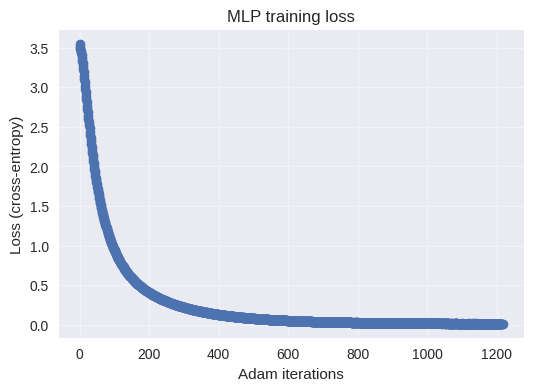

In [65]:
plt.figure(figsize=(6, 4))
plt.plot(localizer.encoder_.loss_curve_, marker='o')  # loss recorded by scikit-learn
plt.title("MLP training loss")
plt.xlabel("Adam iterations")
plt.ylabel("Loss (cross-entropy)")
plt.grid(True, alpha=0.4)
plt.show()


When the loss curve flattens the encoder has converged with the provided hyper-parameters. Otherwise you would adjust `learning_rate_init`, `alpha`, or `max_iter`.

## Phase 4 - Select a sample to inspect

### Train/test split note
The CLI pipeline (Phase 5) uses `train_test_split(..., stratify=y)` with an 80/20 ratio. This notebook section does not re-train; it reuses the entire dataset to illustrate preprocessing. Refer to the CLI or the CI smoke tests for the actual training/evaluation split.

In [66]:
# Define the grid cell (and optionally the campaign) we want to inspect.
TARGET_CELL = '1_4'      # change this to inspect another location
CAMPAIGN_NAME = None      # set to 'ddeuxmetres' or 'dquatremetres' to filter a campaign

subset = df[df['grid_cell'] == TARGET_CELL]
if CAMPAIGN_NAME:
    subset = subset[subset['campaign'] == CAMPAIGN_NAME]
if subset.empty:
    raise ValueError(f"No sample found for {TARGET_CELL} (campaign={CAMPAIGN_NAME}).")

# Random but reproducible pick thanks to random_state.
sample = subset.sample(1, random_state=7)
sample_features = sample[FEATURE_COLUMNS]
sample_meta = sample[['grid_cell', 'grid_x', 'grid_y', 'coord_x_m', 'coord_y_m', 'campaign']]

display(Markdown(
    f"### Selected sample: cell `{sample_meta.iloc[0]['grid_cell']}` (campaign `{sample_meta.iloc[0]['campaign']}`)"
))
display(sample_features)
display(sample_meta)


### Selected sample: cell `1_4` (campaign `dquatremetres`)

,Signal,Noise,signal_A1,signal_A2,signal_A3
1187,-38,-95,-52,-39,-46


,grid_cell,grid_x,grid_y,coord_x_m,coord_y_m,campaign
1187,1_4,1,4,1.125,0.45,dquatremetres


This cell selects the sample to analyze (`TARGET_CELL`) and produces two frames:
- `sample_features`: the five RSSI features passed to the model,
- router distance is kept only as metadata and excluded from the input space,
- `sample_meta`: grid indices, physical coordinates and campaign metadata used for validation.

### 4.1 - Standardization (centering / scaling)

In [67]:
# The scaler stores the training-set mean and standard deviation for each feature.
scaler = localizer.scaler_
raw_vec = sample_features.to_numpy()
scaled_vec = scaler.transform(raw_vec)

scaling_table = pd.DataFrame(
    {
        'feature': FEATURE_COLUMNS,
        'raw_value': raw_vec.flatten(),
        'training_mean': scaler.mean_,
        'training_std': scaler.scale_,
        'standardized_value': scaled_vec.flatten(),
    }
)
display(scaling_table)


,feature,raw_value,training_mean,training_std,standardized_value
0,Signal,-38,-35.570588,4.877863,-0.498048
1,Noise,-95,-95.000000,1.000000,0.000000
2,signal_A1,-52,-40.864706,6.363101,-1.749979
3,signal_A2,-39,-40.696324,5.092929,0.333074
4,signal_A3,-46,-43.472794,6.261636,-0.403602


`StandardScaler` enforces zero mean and unit variance for every feature. Without this normalization `Signal` could dominate the MLP gradients and the Euclidean distance used by L-KNN; scaling balances every RSSI feature.

### 4.2 - Physical location of the sample

In [68]:

coord_text = (
    f"Physical coordinates (m): x = {sample_meta.iloc[0]['coord_x_m']:.3f}, y = {sample_meta.iloc[0]['coord_y_m']:.3f}<br>"
    f"Grid index: (grid_x={sample_meta.iloc[0]['grid_x']}, grid_y={sample_meta.iloc[0]['grid_y']})"
)
display(Markdown(coord_text))


Physical coordinates (m): x = 1.125, y = 0.450<br>Grid index: (grid_x=1, grid_y=4)

Physical coordinates (meters) are also used when computing the Euclidean localization error `error_m = ||coord_true - coord_pred||`. The values correspond to the center of the instrumented cell.

### 4.3 - Propagate through the neural network

In [69]:

# Pass through every MLP layer to inspect how the sample is transformed.
activations = []
activation = scaled_vec
weight_count = len(localizer.encoder_.coefs_)
for idx, (weights, bias) in enumerate(zip(localizer.encoder_.coefs_, localizer.encoder_.intercepts_)):
    linear = activation @ weights + bias  # linear transformation of the current layer
    is_output = idx == weight_count - 1
    layer_name = 'output_logits' if is_output else f'hidden_{idx+1}'
    if not is_output:
        activation = _apply_activation(linear, localizer.encoder_.activation)
    else:
        activation = linear
    activations.append(
        {
            'layer': layer_name,
            'units': linear.shape[1],
            'min': float(activation.min()),
            'max': float(activation.max()),
            'preview_first5': np.round(activation[0, :5], 4).tolist(),
        }
    )

display(pd.DataFrame(activations))


,layer,units,min,max,preview_first5
0,hidden_1,64,0.000000,4.720502,"[3.474, 0.0, 0.0, 1.3752, 3.9992]"
1,hidden_2,32,0.000000,35.471124,"[8.8822, 31.3181, 0.0, 24.1213, 0.0]"
2,output_logits,34,-148.253027,33.873747,"[13.6177, -59.8276, -24.7778, -49.9872, 1.394]"


Each hidden layer applies a linear transformation followed by the activation (`ReLU`). The min/max columns make it easy to check that the activations are not saturated. The embedding consumed by L-KNN is simply the last hidden layer (32 values).

In [70]:

embedding = localizer.transform(sample_features)
print(f"Taille de l'embedding : {embedding.shape}")
embedding_df = pd.DataFrame(embedding, columns=[f"e{i}" for i in range(embedding.shape[1])])
display(embedding_df.round(4))


Taille de l'embedding : (1, 32)


,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,...,e22,e23,e24,e25,e26,e27,e28,e29,e30,e31
0,8.8822,31.3181,0.0,24.1213,0.0,0.0,0.0,0.0,16.5873,16.1758,...,7.6402,18.4815,12.1134,0.0,0.0,2.3689,0.0,10.3072,0.0,0.0


The 32-component vector (`e0..e31`) is the input to the L-KNN. Cells that are close in the physical grid should produce embeddings that are close in this space; otherwise the neighbor search would be unstable.

Note : `neighbor_i_embedding_distance` est une distance dans l'espace latent du MLP (pas une distance physique) et est distincte de la distance routeur (2 m / 4 m) prédite par la tête LogReg.

## Phase 5 - L-KNN decision

### 5.0 - Heatmap of average RSSI
Before analyzing a specific sample we plot the mean `Signal` per cell to ensure the spatial gradient still reflects the router placement.

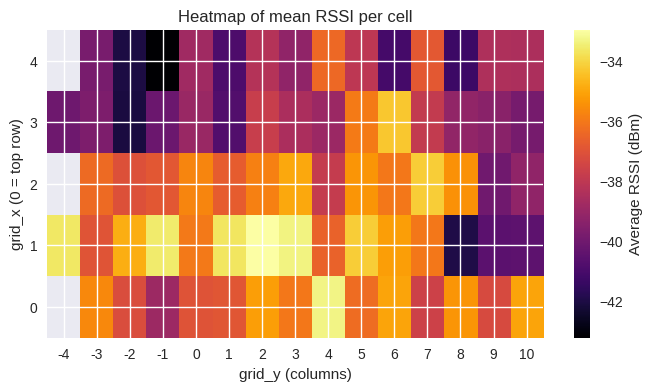

In [71]:
mean_signal = df.pivot_table(index='grid_x', columns='grid_y', values='Signal', aggfunc='mean')
plt.figure(figsize=(8, 4))
plt.imshow(mean_signal.sort_index(ascending=False), cmap='inferno', aspect='auto')
plt.colorbar(label='Average RSSI (dBm)')
plt.title('Heatmap of mean RSSI per cell')
plt.xlabel('grid_y (columns)')
plt.ylabel('grid_x (0 = top row)')
plt.xticks(range(mean_signal.shape[1]), mean_signal.columns)
plt.yticks(range(mean_signal.shape[0]), sorted(mean_signal.index, reverse=True))
plt.show()


In [72]:
# Retrieve the cell probabilities, final prediction, and the K nearest neighbors.
y_proba = localizer.predict_proba(sample_features)
y_pred = localizer.predict(sample_features)
neighbor_dist, neighbor_cells = localizer.explain(sample_features, top_k=5)

print(f"Predicted cell: {y_pred[0]} | max confidence: {y_proba.max():.4f}")

neighbor_df = pd.DataFrame(
    {
        'rank': np.arange(1, neighbor_cells.shape[1] + 1),
        'cell': neighbor_cells[0],
        'distance_embedding': neighbor_dist[0],
    }
)
neighbor_df = neighbor_df.join(cell_lookup, on='cell')
display(neighbor_df)


Predicted cell: 1_4 | max confidence: 1.0000


,rank,cell,distance_embedding,grid_x,grid_y,coord_x_m,coord_y_m,campaign
0,1,1_4,0.0,1,4,1.125,0.45,ddeuxmetres
1,2,1_4,0.0,1,4,1.125,0.45,ddeuxmetres
2,3,1_4,0.0,1,4,1.125,0.45,ddeuxmetres
3,4,1_4,0.0,1,4,1.125,0.45,ddeuxmetres
4,5,1_4,0.0,1,4,1.125,0.45,ddeuxmetres


`neighbor_df` lists the `K` reference cells sorted by Euclidean distance in the latent space. It doubles as an explainability artifact: you know exactly which historical fingerprints contributed to the final decision.

### Recap: Step 4 – Local KNN inference
Once the MLP encoder produces embeddings for the selected sample, the L-KNN searches the training embeddings, retrieves the K nearest neighbors, and votes the cell ID. The tables and plots below expose that neighborhood to explain the prediction.

### 5.1 - Histogram of neighbor distances
Each bar corresponds to one of the `K` neighbors returned by L-KNN. We label the x-axis with the neighbor rank so repeated cell names do not overlap.

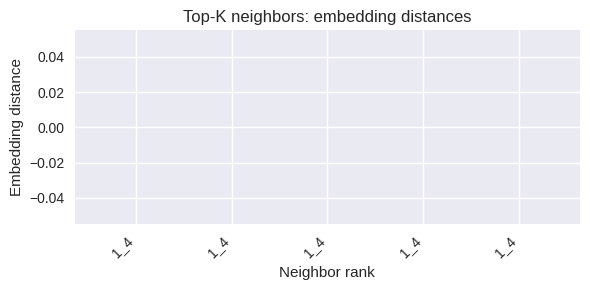

In [73]:
plt.figure(figsize=(6, 3))
plt.bar(neighbor_df['rank'], neighbor_df['distance_embedding'], color='dodgerblue')
plt.xticks(neighbor_df['rank'], neighbor_df['cell'], rotation=45, ha='right')
plt.xlabel('Neighbor rank')
plt.ylabel('Embedding distance')
plt.title('Top-K neighbors: embedding distances')
plt.tight_layout()
plt.show()


### 5.2 - Neighbor vote contributions
Distances are converted to weights (`1/distance`) to visualize how much each neighbor contributes to the L-KNN vote. The weights sum to 1.

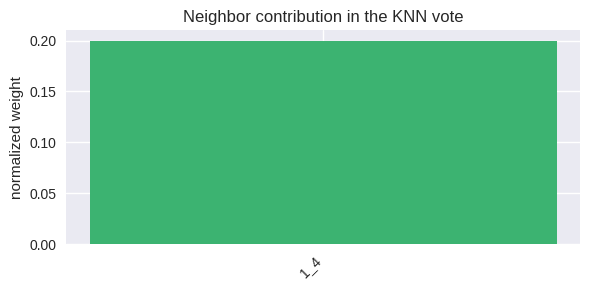

In [74]:
weights = 1 / (neighbor_df['distance_embedding'] + 1e-6)
weights = weights / weights.sum()
plt.figure(figsize=(6, 3))
plt.bar(neighbor_df['cell'], weights, color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.ylabel('normalized weight')
plt.title('Neighbor contribution in the KNN vote')
plt.tight_layout()
plt.show()


### 5.3 - Project neighbors on the board picture

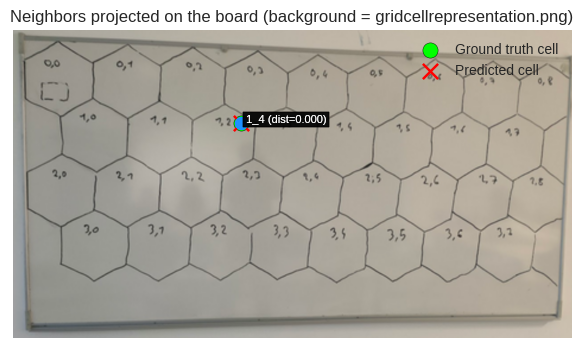

In [75]:

if GRID_IMAGE_PATH.exists():
    img = plt.imread(GRID_IMAGE_PATH)  # background picture of the magnetic board
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.imshow(img)

    def cell_to_pixels(cell_name: str):
        """Map a cell identifier to pixel coordinates on the image."""
        entry = cell_lookup.loc[cell_name]
        x_norm = entry['coord_x_m'] / GRID_WIDTH_M
        y_norm = entry['coord_y_m'] / GRID_HEIGHT_M
        px = x_norm * img.shape[1]
        py = y_norm * img.shape[0]
        return px, py

    # Actual vs predicted position of the inspected sample.
    true_px, true_py = cell_to_pixels(sample_meta.iloc[0]['grid_cell'])
    pred_px, pred_py = cell_to_pixels(y_pred[0])

    ax.scatter([true_px], [true_py], c='lime', s=120, marker='o', edgecolors='black', label='Ground truth cell')
    ax.scatter([pred_px], [pred_py], c='red', s=120, marker='x', label='Predicted cell')

    # Visualize the K neighbors that influenced the vote.
    for _, row in neighbor_df.iterrows():
        px, py = cell_to_pixels(row['cell'])
        ax.scatter(px, py, c='dodgerblue', s=80, alpha=0.7)
        label_txt = f"{row['cell']} (dist={row['distance_embedding']:.3f})"
        ax.text(
            px + 10,
            py,
            label_txt,
            color='white',
            fontsize=8,
            bbox=dict(facecolor='black', alpha=0.4, pad=2),
        )

    ax.set_title('Neighbors projected on the board (background = gridcellrepresentation.png)')
    ax.axis('off')
    ax.legend(loc='upper right')
    plt.show()
else:
    print("Image lesgridcells.png missing: overlay cannot be displayed.")


### 5.4 - Confusion matrix and reliability curve
- The confusion matrix (saved by `localization.pipeline`) highlights cells that are systematically confused.
- The reliability curve plots average model confidence vs observed accuracy to validate probability calibration.
- The bar chart shows how confidence scores are distributed across all measurements.
- `confusion_cell_distance_with_logreg.png` affiche la matrice pour le couple (cellule, distance routeur prédite) afin de vérifier que la bonne distance de campagne est identifiée.- `confusion_cell_distance_without_logreg.png` compare la même matrice (cellule + distance) avec une baseline simple: distance = mode observée pour la cellule prédite.


### Confusion matrix (cells)

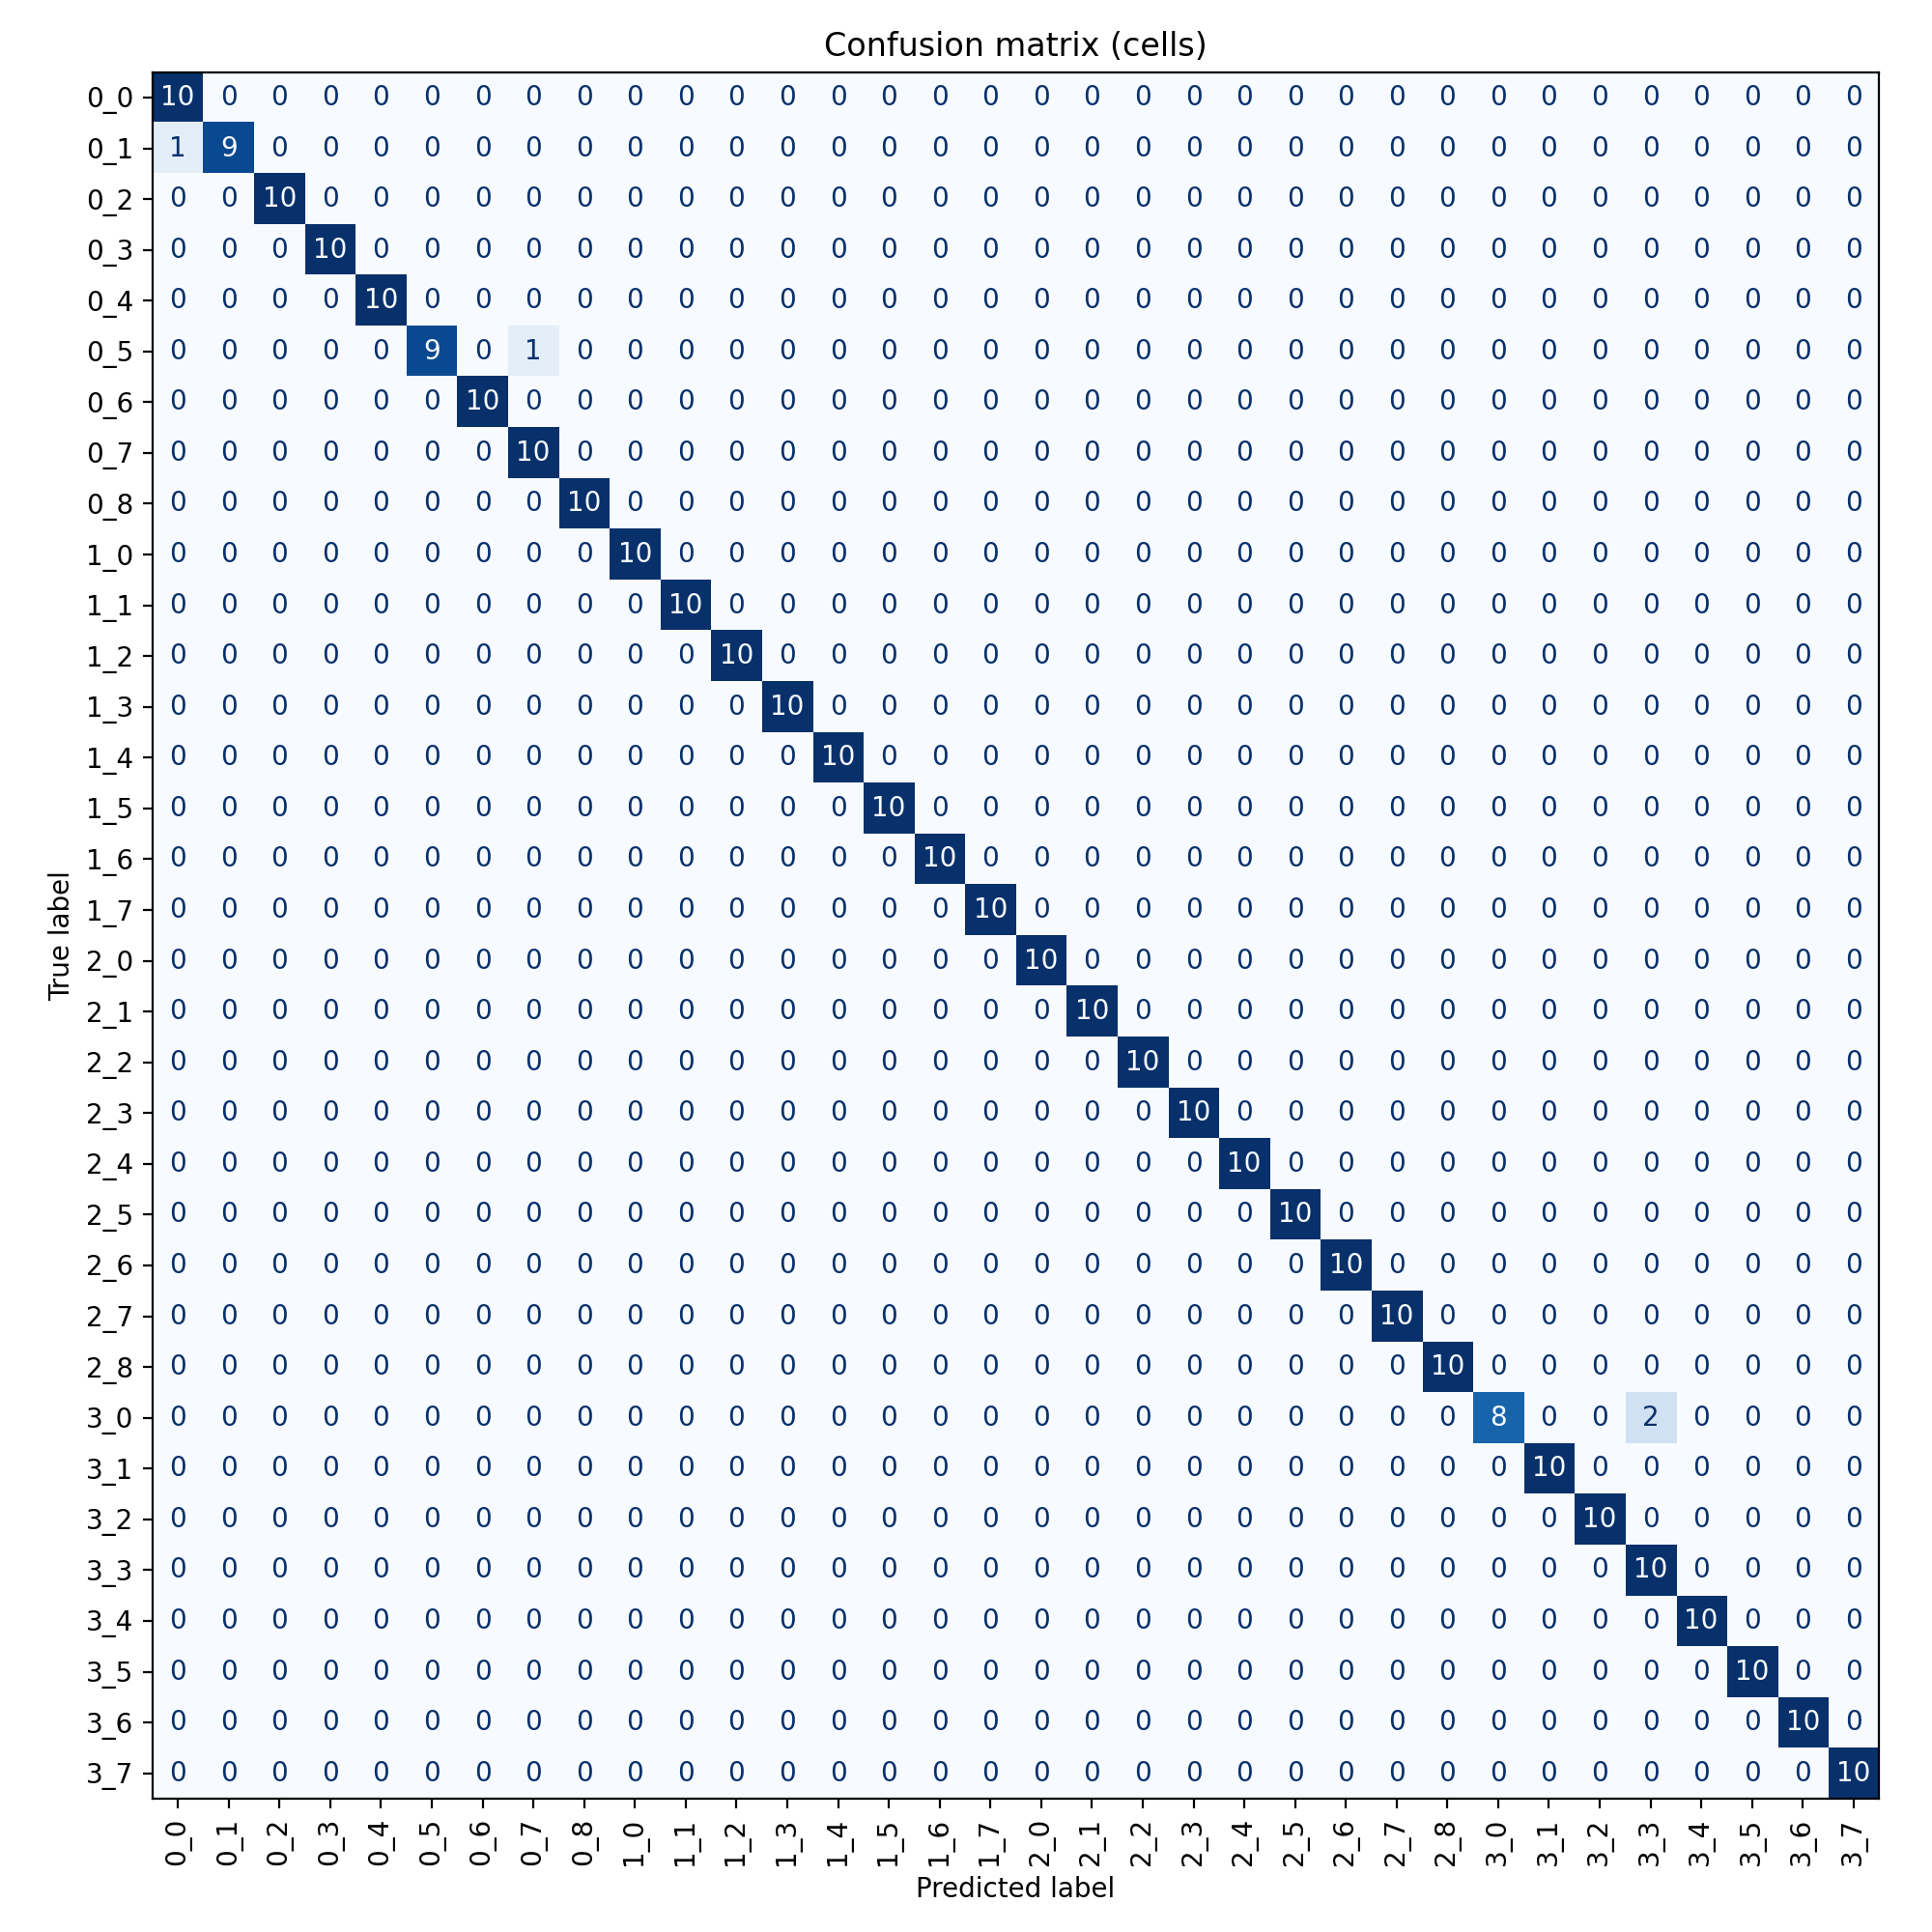

### Confusion matrix (cell + router distance, LogReg head)

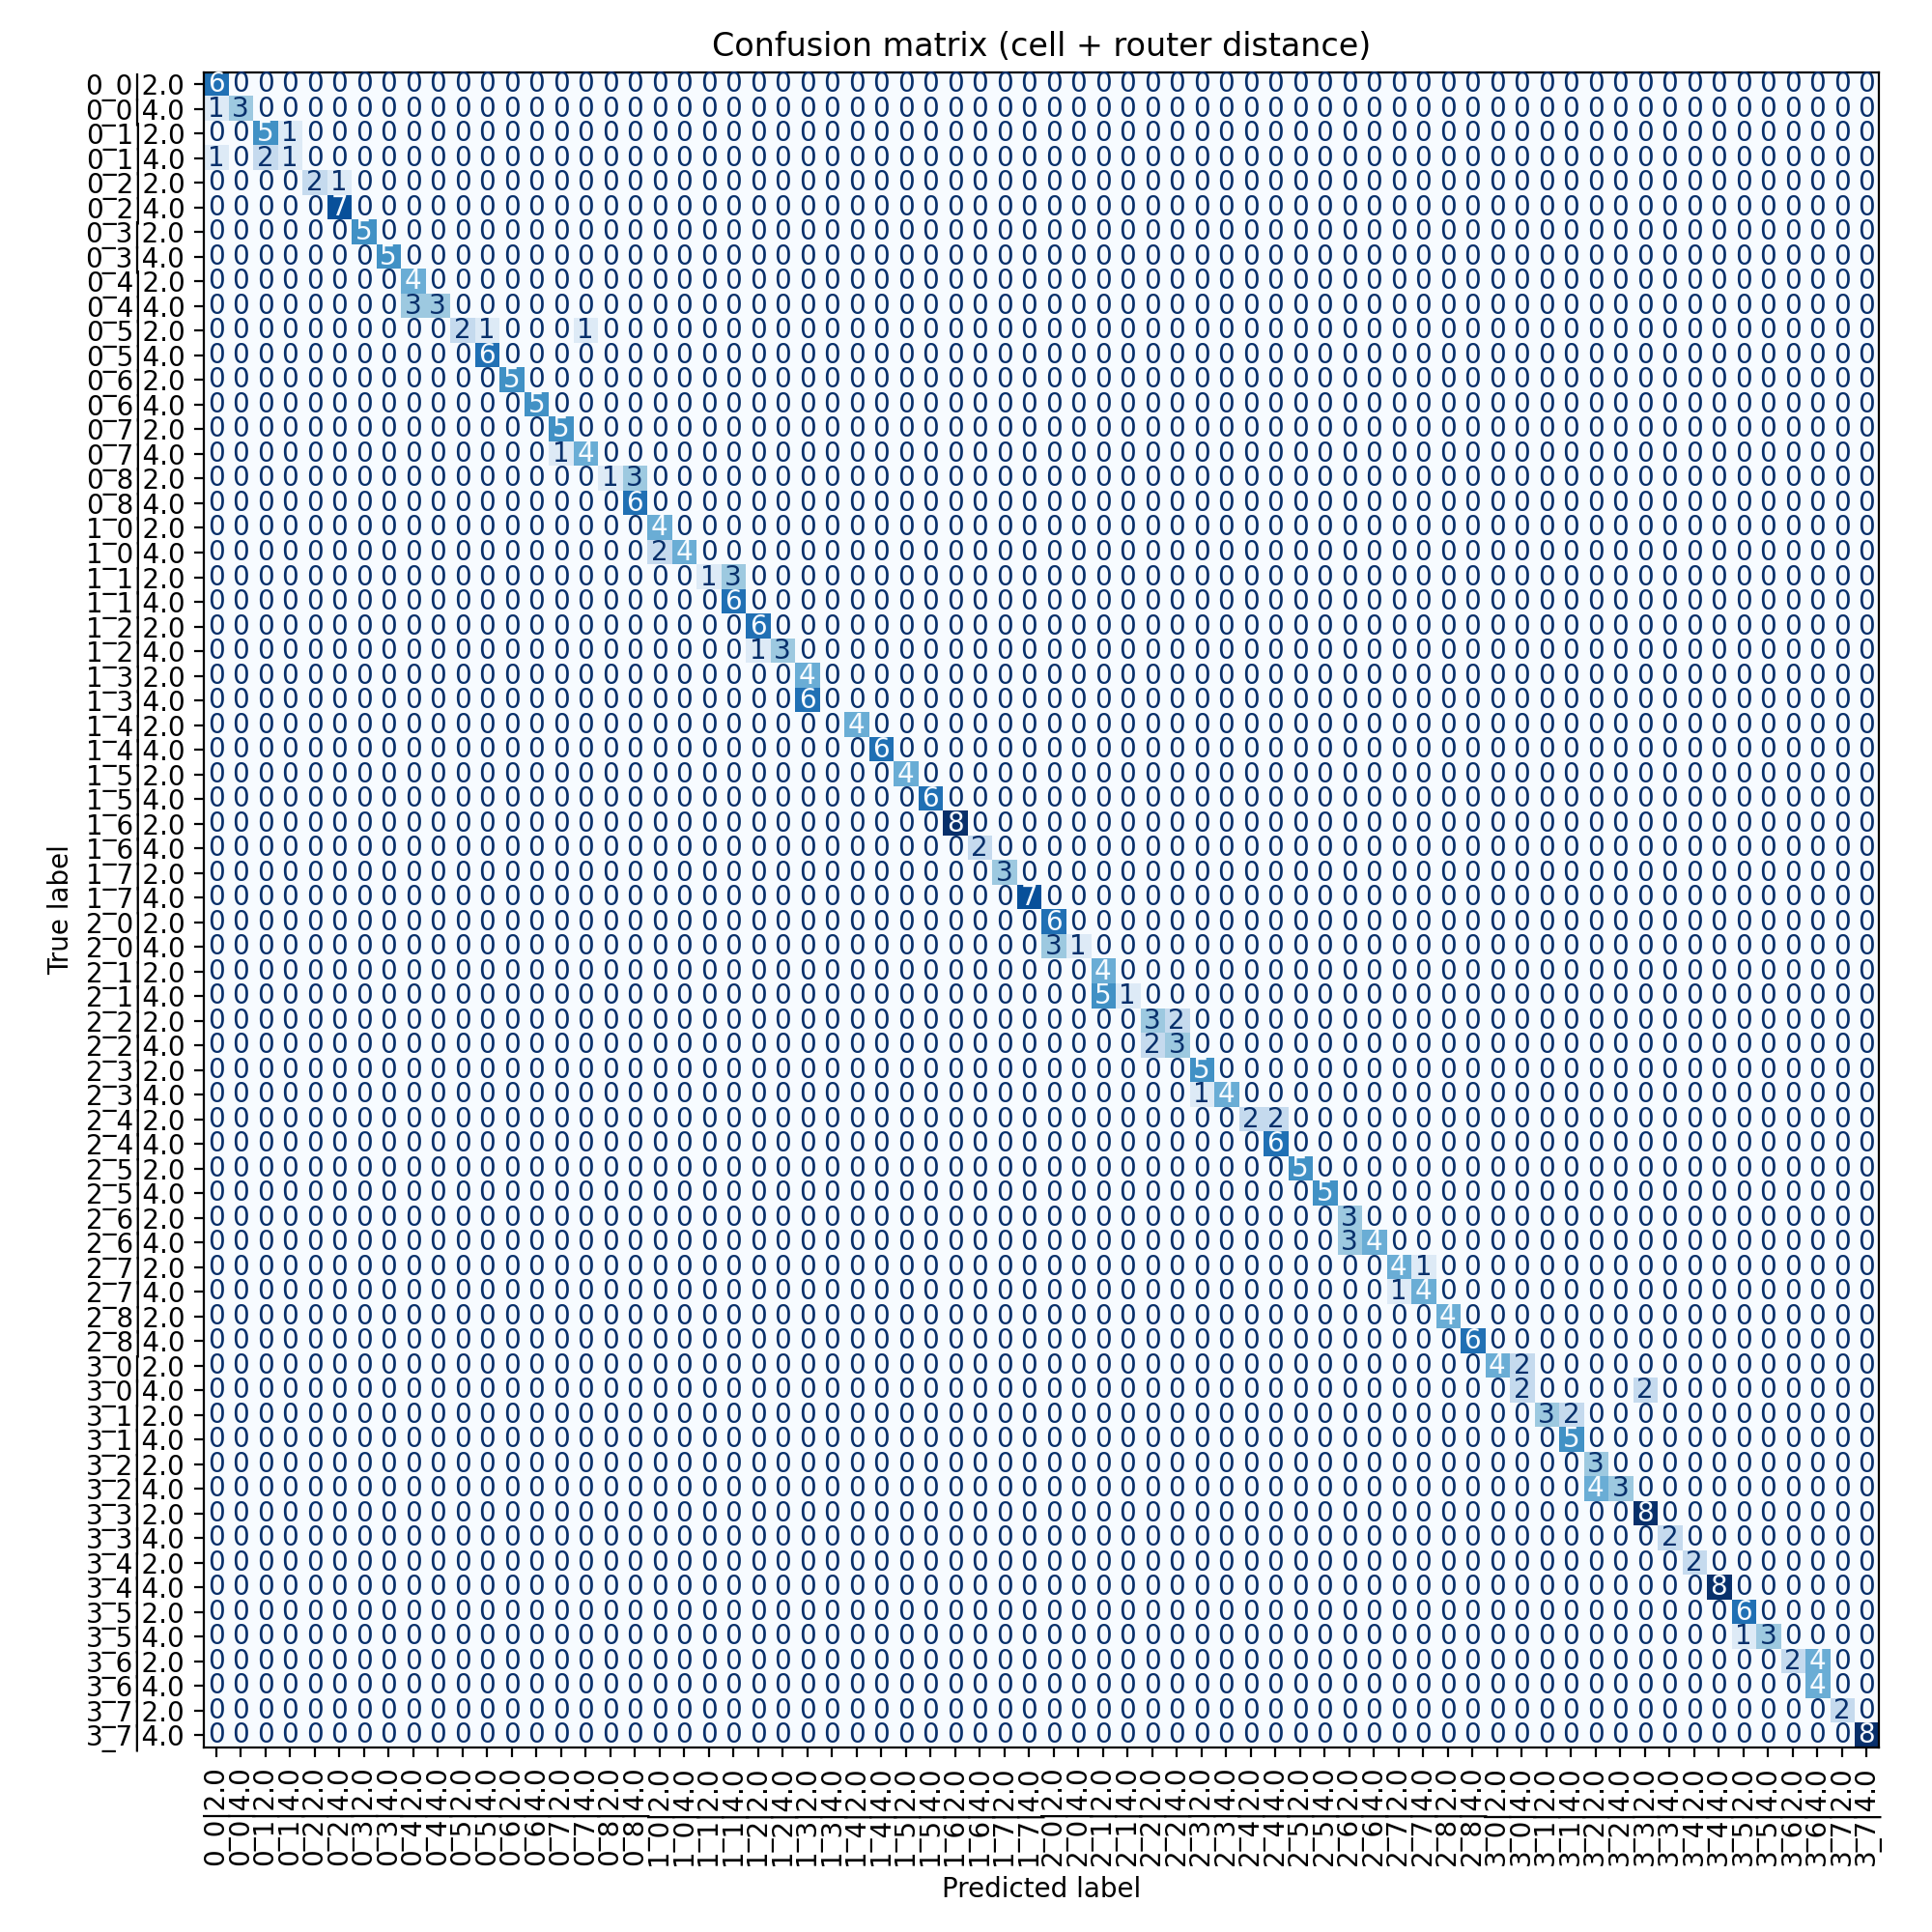

### Confusion matrix (cell + router distance, baseline mode per cell)

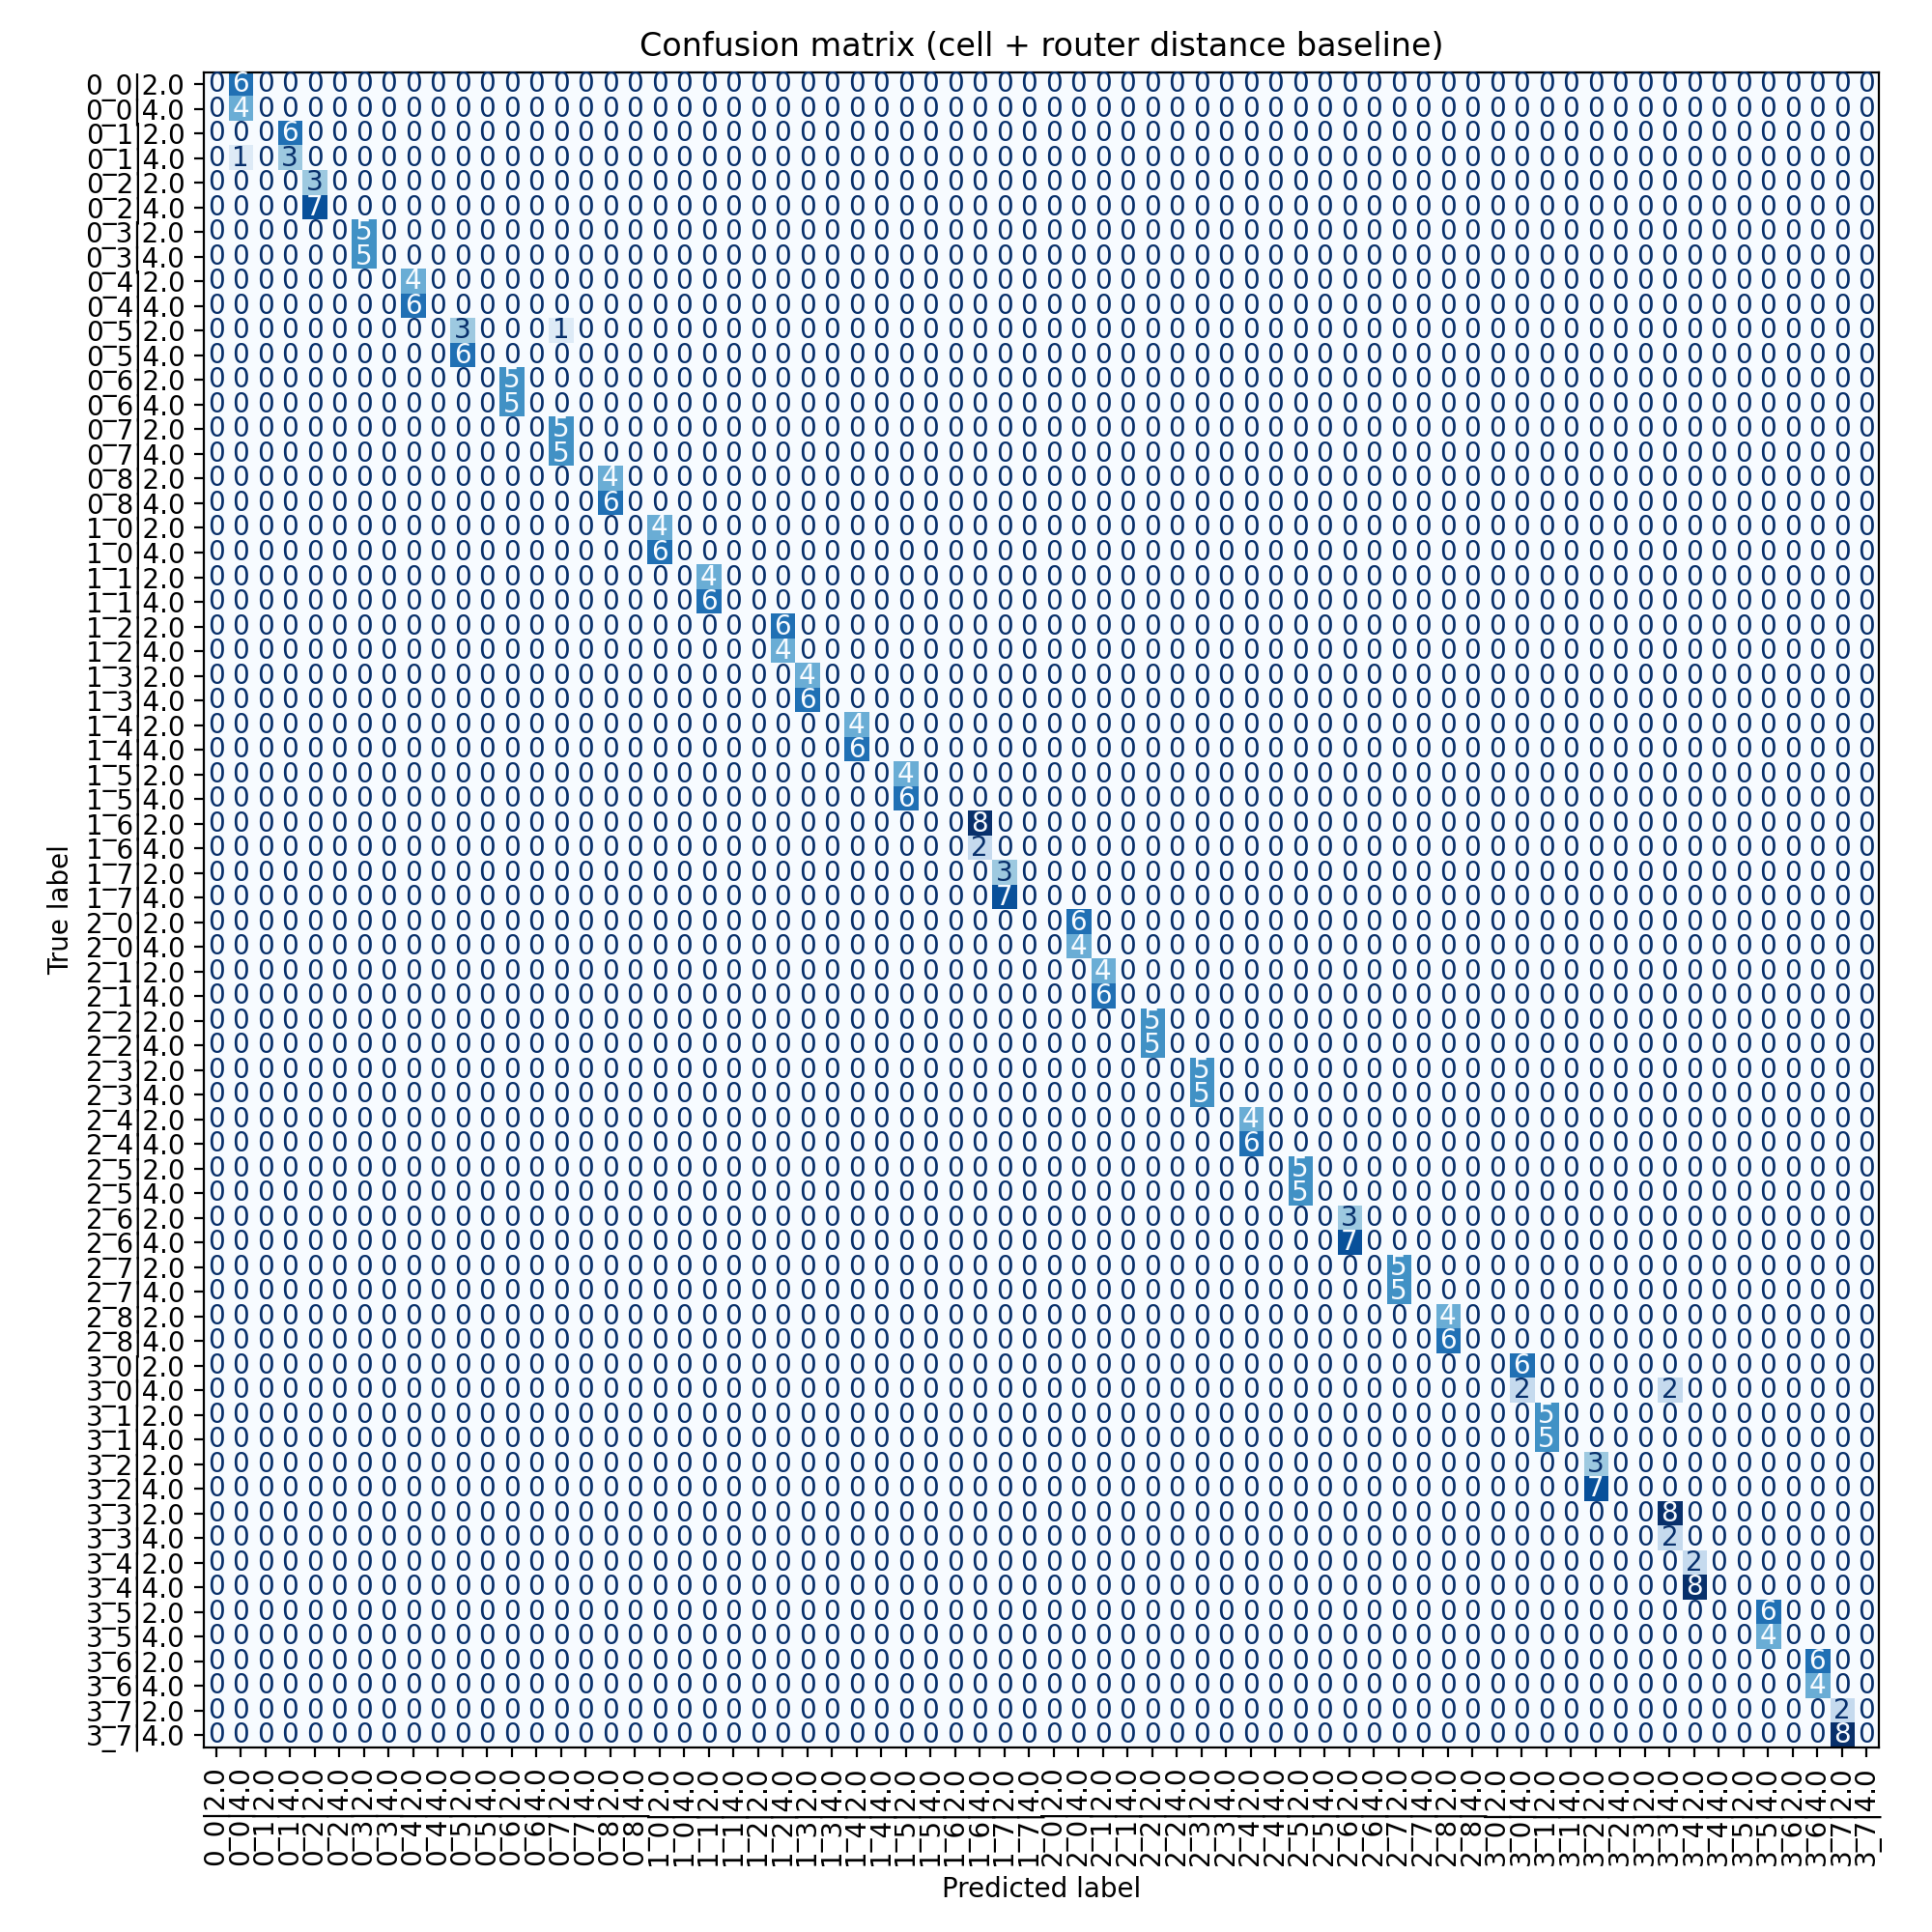

Router-distance accuracy -> LogReg head: 0.818 | baseline (mode per cell): 0.388


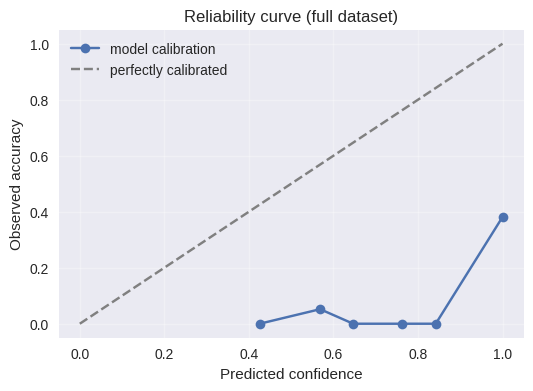

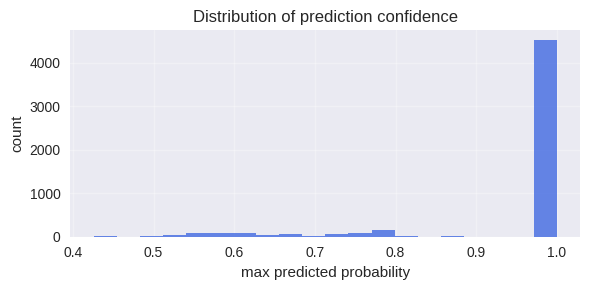

In [76]:
# Display the confusion matrix generated by the training pipeline
confusion_path = REPORTS_DIR / 'confusion_matrix.png'
confusion_combo_logreg = REPORTS_DIR / 'confusion_cell_distance_with_logreg.png'
confusion_combo_baseline = REPORTS_DIR / 'confusion_cell_distance_without_logreg.png'

for name, path in [
    ("Confusion matrix (cells)", confusion_path),
    ("Confusion matrix (cell + router distance, LogReg head)", confusion_combo_logreg),
    ("Confusion matrix (cell + router distance, baseline mode per cell)", confusion_combo_baseline),
]:
    if path.exists():
        display(Markdown(f"### {name}"))
        display(Image(filename=path))
    else:
        print(f"{path.name} missing: rerun localization.pipeline to regenerate it.")

# Print router-distance accuracies from latest_metrics.json if available
metrics_path = REPORTS_DIR / 'latest_metrics.json'
if metrics_path.exists():
    try:
        import json as _json
        m = _json.loads(metrics_path.read_text())
        acc = m.get('router_distance_accuracy')
        acc_base = m.get('router_distance_accuracy_baseline')
        if acc is not None and acc_base is not None:
            print(f"Router-distance accuracy -> LogReg head: {acc:.3f} | baseline (mode per cell): {acc_base:.3f}")
    except Exception as exc:
        print(f"Warning: unable to read metrics: {exc}")

# Reliability curve on the entire dataset
all_probs = localizer.predict_proba(df[FEATURE_COLUMNS])
all_preds = localizer.predict(df[FEATURE_COLUMNS])
true_cells = df['grid_cell'].to_numpy()

from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(
    (all_preds == true_cells).astype(int), all_probs.max(axis=1), n_bins=10
)
plt.figure(figsize=(6, 4))
plt.plot(prob_pred, prob_true, marker='o', label='model calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='perfectly calibrated')
plt.xlabel('Predicted confidence')
plt.ylabel('Observed accuracy')
plt.title('Reliability curve (full dataset)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Histogram of confidence scores
plt.figure(figsize=(6, 3))
plt.hist(all_probs.max(axis=1), bins=20, color='royalblue', alpha=0.8)
plt.xlabel('max predicted probability')
plt.ylabel('count')
plt.title('Distribution of prediction confidence')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Recap: Step 5 – Evaluation metrics
The CLI pipeline and CI smoke tests compute accuracy, mean distance error, ROC AUC, and confidence calibration on the stratified test set. The reliability/ confusion outputs displayed here are the same artifacts, reproduced so you can verify that the model still meets the expected precision goals.

This figure brings everything together: green = ground truth cell, red = predicted cell, blue markers = the neighbor cells consulted by the L-KNN.

## Next steps
- Modify `TARGET_CELL` / `CAMPAIGN_NAME` to validate other positions or router distances.
- Add new measurement campaigns (different router heights, obstacles, etc.) and re-run the notebook to stress the embeddings.



## D005 / E101 – variantes salle-agnostique et salle-aware
Nous ajoutons trois scénarios complémentaires basés sur les campagnes multi-salles (en excluant `circulaire`) :
- NN + L-KNN sans feature de salle (leave-one-room-out) pour évaluer la généralisation.
- NN + L-KNN avec la salle encodée en one-hot (cas où la salle est connue à l'inférence).
- Une tête Logistic Regression pour prédire la distance routeur (2/3/4/5 m) à partir de l'embedding.


In [77]:

from localization.embedding_knn import EmbeddingKnnConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Campagnes non circulaires par salle.
ROOM_CAMPAIGNS = {
    "D005": [
        PROJECT_ROOT / "data" / "D005" / "ddeuxmetres",
        PROJECT_ROOT / "data" / "D005" / "dquatremetres",
    ],
    "E101": [
        PROJECT_ROOT / "data" / "E101" / "dtroismetres",
        PROJECT_ROOT / "data" / "E101" / "dcinqmetres",
    ],
}

room_specs: list[tuple[str, CampaignSpec]] = []
missing = []
for room, folders in ROOM_CAMPAIGNS.items():
    for folder in folders:
        if folder.exists():
            room_specs.append((room, CampaignSpec(folder)))
        else:
            missing.append(folder)

if missing:
    print("Ignored missing folders:", [p.name for p in missing])

frames = []
for room, spec in room_specs:
    df_room = load_measurements([spec])
    df_room["room"] = room
    # Garder la granularité campagne + salle pour le debug.
    df_room["campaign"] = f"{room}/{spec.path.name}"
    frames.append(df_room)

if not frames:
    raise RuntimeError("Aucune campagne croisée trouvée. Vérifie les dossiers data/D005 et data/E101.")

cross_room_df = pd.concat(frames, ignore_index=True)
room_dummies = pd.get_dummies(cross_room_df["room"], prefix="room")
cross_room_df = pd.concat([cross_room_df, room_dummies], axis=1)
ROOM_OHE_COLUMNS = room_dummies.columns.tolist()

cell_lookup_all = (
    cross_room_df[["grid_cell", "grid_x", "grid_y", "coord_x_m", "coord_y_m"]]
    .drop_duplicates("grid_cell")
    .set_index("grid_cell")
)

print(
    f"Dataset cross-room: {len(cross_room_df)} lignes | salles={sorted(cross_room_df['room'].unique())} | "
    f"cells={cross_room_df['grid_cell'].nunique()} | distances={sorted(cross_room_df['router_distance_m'].unique())}"
)
display(cross_room_df.groupby(["room", "campaign", "router_distance_m"]).size())


Dataset cross-room: 5300 lignes | salles=['D005', 'E101'] | cells=72 | distances=[np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0)]


room  campaign            router_distance_m
D005  D005/ddeuxmetres    2.0                   850
      D005/dquatremetres  4.0                   850
E101  E101/dcinqmetres    5.0                  1800
      E101/dtroismetres   3.0                  1800
dtype: int64


### Helpers (features, métriques, tête distance)
Les helpers ci-dessous factorisent la construction des features (avec ou sans salle), 
le fit du NN+L-KNN et la tête Logistic Regression pour la distance routeur.


In [78]:

def build_features(df, include_room: bool):
    base = df[FEATURE_COLUMNS]
    if not include_room:
        return base.to_numpy()
    extras = df[ROOM_OHE_COLUMNS]
    return pd.concat([base.reset_index(drop=True), extras.reset_index(drop=True)], axis=1).to_numpy()

def fit_nn_lknn(train_df, include_room: bool, **config_overrides):
    cfg_kwargs = {
        "hidden_layer_sizes": (64, 32),
        "k_neighbors": 5,
        "learning_rate_init": 1e-3,
        "alpha": 1e-4,
        "max_iter": 1200,
        "random_state": 7,
    }
    cfg_kwargs.update(config_overrides)
    cfg = EmbeddingKnnConfig(**cfg_kwargs)
    model = EmbeddingKnnLocalizer(config=cfg)
    model.fit(build_features(train_df, include_room), train_df["grid_cell"])
    return model

def localization_summary(test_df, y_pred):
    pred_meta = cell_lookup_all.loc[y_pred]
    true_coords = test_df[["coord_x_m", "coord_y_m"]].to_numpy()
    pred_coords = pred_meta[["coord_x_m", "coord_y_m"]].to_numpy()
    errors_m = np.linalg.norm(true_coords - pred_coords, axis=1)
    return {
        "cell_acc": float((y_pred == test_df["grid_cell"].to_numpy()).mean()),
        "mean_error_m": float(errors_m.mean()),
        "p90_error_m": float(np.percentile(errors_m, 90)),
    }

def train_distance_head(model, train_df, test_df, include_room: bool):
    train_emb = model.transform(build_features(train_df, include_room))
    test_emb = model.transform(build_features(test_df, include_room))
    distance_clf = LogisticRegression(max_iter=5000, solver="lbfgs")
    distance_clf.fit(train_emb, train_df["router_distance_m"])
    dist_pred = distance_clf.predict(test_emb)
    return distance_clf, float(accuracy_score(test_df["router_distance_m"], dist_pred))



### NN + L-KNN sans salle (leave-one-room-out) + tête distance
On entraîne sans feature `room` et on évalue en tenant une salle complète à l'écart
(simule une salle jamais vue). La tête LogReg distance est entraînée uniquement si toutes
les classes de distance présentes en test existent dans le train correspondant.


In [79]:

room_agnostic_rows = []
for held_out_room in sorted(cross_room_df["room"].unique()):
    train_df = cross_room_df[cross_room_df["room"] != held_out_room]
    test_df = cross_room_df[cross_room_df["room"] == held_out_room]

    model_no_room = fit_nn_lknn(train_df, include_room=False)
    y_pred = model_no_room.predict(build_features(test_df, include_room=False))
    metrics = localization_summary(test_df, y_pred)

    # Distance head (only if all distances present in train to avoid unseen labels).
    dist_clf = None
    dist_acc = np.nan
    if set(test_df["router_distance_m"]).issubset(set(train_df["router_distance_m"])):
        dist_clf, dist_acc = train_distance_head(model_no_room, train_df, test_df, include_room=False)

    row = {"held_out_room": held_out_room, "n_test": len(test_df), **metrics, "router_distance_acc": dist_acc}
    room_agnostic_rows.append(row)

room_agnostic_results = pd.DataFrame(room_agnostic_rows)
room_agnostic_results


,held_out_room,n_test,cell_acc,mean_error_m,p90_error_m,router_distance_acc
0,D005,1700,0.016471,1.180475,2.088061,NaN
1,E101,3600,0.010556,1.190620,2.022375,NaN



### NN + L-KNN avec salle connue (one-hot) + tête distance
Cas où la salle est fournie à l'inférence. On fait un split stratifié 80/20
qui mélange les salles mais inclut la colonne `room_*`.


In [80]:

from tqdm.auto import tqdm

with tqdm(total=3, desc="Room-aware evaluation") as pbar:
    room_aware_train, room_aware_test = train_test_split(
        cross_room_df,
        test_size=0.2,
        random_state=21,
        stratify=cross_room_df["grid_cell"],
    )
    pbar.update(1)

    model_with_room = fit_nn_lknn(room_aware_train, include_room=True)
    y_pred_room = model_with_room.predict(build_features(room_aware_test, include_room=True))
    room_aware_metrics = localization_summary(room_aware_test, y_pred_room)
    pbar.update(1)

    _, room_distance_acc = train_distance_head(model_with_room, room_aware_train, room_aware_test, include_room=True)
    pbar.update(1)

print("Room-aware cell accuracy = {cell_acc:.3f}, mean error = {mean_error_m:.3f} m, p90 = {p90_error_m:.3f} m".format(**room_aware_metrics))
print(f"Room-aware router distance accuracy (LogReg head): {room_distance_acc:.3f}")


Room-aware evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Room-aware cell accuracy = 0.973, mean error = 0.033 m, p90 = 0.000 m
Room-aware router distance accuracy (LogReg head): 0.768



### LogReg dédiée à la distance routeur (embedding NN sans salle)
On sépare 80/20 stratifié sur la distance, encode en embedding avec le modèle
sans salle, puis on entraîne une LogisticRegression multi-classes (2/3/4/5 m).


In [ ]:

distance_train, distance_test = train_test_split(
    cross_room_df,
    test_size=0.2,
    random_state=33,
    stratify=cross_room_df["router_distance_m"],
)

base_model_distance = fit_nn_lknn(distance_train, include_room=False, random_state=33)
train_emb = base_model_distance.transform(build_features(distance_train, include_room=False))
test_emb = base_model_distance.transform(build_features(distance_test, include_room=False))

distance_logreg = LogisticRegression(max_iter=5000, solver="lbfgs")
distance_logreg.fit(train_emb, distance_train["router_distance_m"])

dist_pred = distance_logreg.predict(test_emb)
dist_acc = accuracy_score(distance_test["router_distance_m"], dist_pred)
dist_proba = distance_logreg.predict_proba(test_emb)

print(f"Router distance accuracy (stratified split, room-agnostic embedding): {dist_acc:.3f}")
# Confusion normalisée par classe pour visualiser où ça coince.
dist_confusion = pd.crosstab(distance_test["router_distance_m"], dist_pred, normalize="index").round(3)
dist_confusion



### Lancer le benchmark complet (NN+L-KNN vs RF)
Ce bloc exécute `scripts/benchmark_models.py` : room-agnostic (leave-one-room-out), room-aware (salle connue),
tête LogReg distance et classif de salle. La sortie console affiche toutes les métriques.


In [ ]:

import subprocess
from pathlib import Path

BENCH_SCRIPT = PROJECT_ROOT / "scripts" / "benchmark_models.py"
print(f"Running benchmark script: {BENCH_SCRIPT}")
result = subprocess.run(["python", str(BENCH_SCRIPT)], capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print("[stderr]\n" + result.stderr)
if result.returncode != 0:
    raise RuntimeError(f"Benchmark failed with code {result.returncode}")

# Lister les matrices de confusion générées pour inspection rapide.
conf_dir = PROJECT_ROOT / "reports" / "benchmarks"
if conf_dir.exists():
    print("\nConfusion matrices generated:")
    for csv_path in sorted(conf_dir.glob("confusion_*.csv")):
        print(" -", csv_path.relative_to(PROJECT_ROOT))
    # Aperçu du premier CSV
    first = next(conf_dir.glob("confusion_*.csv"), None)
    if first:
        import pandas as pd

        print(f"\nPreview of {first.name}:")
        display(pd.read_csv(first).head())
else:
    print("No confusion directory found. Did the benchmark run?")



### TriScope (multihead) + CheckeurFou
TriScope = modèle multi-tâche entraîné uniquement sur les RSSI, qui prédit cellule + distance + salle. CheckeurFou vérifie ensuite les prédictions sur un échantillon aléatoire et signale les écarts.


In [ ]:

from dataclasses import dataclass
from typing import Any, Dict

class TriScope:
    def __init__(self, random_state: int = 64):
        self.random_state = random_state
        self.localizer = None
        self.dist_head = None
        self.room_head = None

    def fit(self, df):
        # Encode RSSI -> embedding via NN+L-KNN (no room, no distance as feature).
        self.localizer = fit_nn_lknn(df, include_room=False, random_state=self.random_state)
        train_emb = self.localizer.transform(build_features(df, include_room=False))

        # Distance head.
        self.dist_head = LogisticRegression(max_iter=800, solver="lbfgs")
        self.dist_head.fit(train_emb, df["router_distance_m"])

        # Room head.
        self.room_head = LogisticRegression(max_iter=800, solver="lbfgs")
        self.room_head.fit(train_emb, df["room"])
        return self

    def predict(self, feature_df):
        X = build_features(feature_df, include_room=False)
        cell_pred = self.localizer.predict(X)
        emb = self.localizer.transform(X)
        dist_pred = self.dist_head.predict(emb)
        room_pred = self.room_head.predict(emb)
        return cell_pred, dist_pred, room_pred

@dataclass
class CheckResult:
    total: int
    cell_errors: int
    distance_errors: int
    room_errors: int


def run_triscope_demo(sample_size: int = 5, seed: int = 42) -> Dict[str, Any]:
    triscope = TriScope().fit(cross_room_df)
    sample = cross_room_df.sample(sample_size, random_state=seed)
    cell_pred, dist_pred, room_pred = triscope.predict(sample)

    result_df = sample[["room", "router_distance_m", "grid_cell"]].copy()
    result_df["pred_room"] = room_pred
    result_df["pred_distance_m"] = dist_pred
    result_df["pred_cell"] = cell_pred

    check = CheckResult(
        total=sample_size,
        cell_errors=int((result_df["grid_cell"] != result_df["pred_cell"]).sum()),
        distance_errors=int((result_df["router_distance_m"] != result_df["pred_distance_m"]).sum()),
        room_errors=int((result_df["room"] != result_df["pred_room"]).sum()),
    )

    display(Markdown("#### TriScope predictions"))
    display(result_df.reset_index(drop=True))

    display(Markdown("#### CheckeurFou verdict"))
    print(f"Samples checked: {check.total}")
    print(f"Cell errors: {check.cell_errors} | Distance errors: {check.distance_errors} | Room errors: {check.room_errors}")

    return {"predictions": result_df, "check": check}

triscope_outputs = run_triscope_demo(sample_size=5, seed=7)


---
# Partie 2 : Visualisations avancées du NN et L-KNN

Cette section ajoute des visualisations interactives pour comprendre en profondeur :
1. **Le réseau de neurones** : activations, poids, feature importance (saliency)
2. **L'espace d'embedding** : séparation par salle, distance routeur, similarité entre cellules
3. **Le flux de prédiction L-KNN** : schéma pipeline, frontières de décision, trajectoire d'un sample

In [ ]:
# ============================================================
# PARTIE 2 - INITIALISATION AUTONOME
# Cette cellule recrée toutes les variables nécessaires pour que
# la Partie 2 fonctionne indépendamment de la Partie 1
# ============================================================

# --- Configuration des chemins et imports de base ---
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Définir PROJECT_ROOT et ajouter src au path
PROJECT_ROOT = Path('..').resolve()
sys.path.append(str(PROJECT_ROOT / 'src'))

# Définir les colonnes de features (même définition que Partie 1)
FEATURE_COLUMNS = ["Signal", "Noise", "signal_A1", "signal_A2", "signal_A3"]

# Imports supplémentaires pour les visualisations avancées
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, Layout
from IPython.display import clear_output
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Couleurs cohérentes pour les salles et distances
ROOM_COLORS = {"D005": "#E74C3C", "E101": "#3498DB"}
DISTANCE_COLORS = {2.0: "#2ECC71", 3.0: "#F39C12", 4.0: "#9B59B6", 5.0: "#E74C3C"}

# --- Recréer cross_room_df si nécessaire ---
if 'cross_room_df' not in dir():
    print("Création de cross_room_df...")
    from localization.data import CampaignSpec, load_measurements
    from localization.embedding_knn import EmbeddingKnnConfig, EmbeddingKnnLocalizer, _apply_activation
    
    ROOM_CAMPAIGNS = {
        "D005": [
            PROJECT_ROOT / "data" / "D005" / "ddeuxmetres",
            PROJECT_ROOT / "data" / "D005" / "dquatremetres",
        ],
        "E101": [
            PROJECT_ROOT / "data" / "E101" / "dtroismetres",
            PROJECT_ROOT / "data" / "E101" / "dcinqmetres",
        ],
    }
    
    room_specs = []
    for room, folders in ROOM_CAMPAIGNS.items():
        for folder in folders:
            if folder.exists():
                room_specs.append((room, CampaignSpec(folder)))
    
    frames = []
    for room, spec in room_specs:
        df_room = load_measurements([spec])
        df_room["room"] = room
        df_room["campaign"] = f"{room}/{spec.path.name}"
        frames.append(df_room)
    
    cross_room_df = pd.concat(frames, ignore_index=True)
    room_dummies = pd.get_dummies(cross_room_df["room"], prefix="room")
    cross_room_df = pd.concat([cross_room_df, room_dummies], axis=1)
    ROOM_OHE_COLUMNS = room_dummies.columns.tolist()
    
    cell_lookup_all = (
        cross_room_df[["grid_cell", "grid_x", "grid_y", "coord_x_m", "coord_y_m"]]
        .drop_duplicates("grid_cell")
        .set_index("grid_cell")
    )
    print(f"  → {len(cross_room_df)} lignes, {cross_room_df['grid_cell'].nunique()} cellules")
else:
    print("cross_room_df déjà chargé.")
    # S'assurer que ROOM_OHE_COLUMNS existe
    if 'ROOM_OHE_COLUMNS' not in dir():
        ROOM_OHE_COLUMNS = [c for c in cross_room_df.columns if c.startswith('room_')]
    if 'cell_lookup_all' not in dir():
        cell_lookup_all = (
            cross_room_df[["grid_cell", "grid_x", "grid_y", "coord_x_m", "coord_y_m"]]
            .drop_duplicates("grid_cell")
            .set_index("grid_cell")
        )

# --- Fonction helper pour construire les features ---
def build_features(df, include_room: bool):
    base = df[FEATURE_COLUMNS]
    if not include_room:
        return base.to_numpy()
    extras = df[ROOM_OHE_COLUMNS]
    return pd.concat([base.reset_index(drop=True), extras.reset_index(drop=True)], axis=1).to_numpy()

# --- Recréer base_model_distance si nécessaire ---
if 'base_model_distance' not in dir():
    print("Entraînement de base_model_distance...")
    from localization.embedding_knn import EmbeddingKnnConfig, EmbeddingKnnLocalizer
    
    distance_train, distance_test = train_test_split(
        cross_room_df,
        test_size=0.2,
        random_state=33,
        stratify=cross_room_df["router_distance_m"],
    )
    
    cfg = EmbeddingKnnConfig(
        hidden_layer_sizes=(64, 32),
        k_neighbors=5,
        learning_rate_init=1e-3,
        alpha=1e-4,
        max_iter=1200,
        random_state=33,
    )
    base_model_distance = EmbeddingKnnLocalizer(config=cfg)
    base_model_distance.fit(build_features(distance_train, include_room=False), distance_train["grid_cell"])
    print("  → Modèle entraîné.")
else:
    print("base_model_distance déjà chargé.")
    # Recréer distance_train/test si manquants
    if 'distance_train' not in dir() or 'distance_test' not in dir():
        distance_train, distance_test = train_test_split(
            cross_room_df,
            test_size=0.2,
            random_state=33,
            stratify=cross_room_df["router_distance_m"],
        )

# --- Recréer distance_logreg si nécessaire ---
if 'distance_logreg' not in dir():
    print("Entraînement de distance_logreg...")
    train_emb = base_model_distance.transform(build_features(distance_train, include_room=False))
    distance_logreg = LogisticRegression(max_iter=5000, solver="lbfgs")
    distance_logreg.fit(train_emb, distance_train["router_distance_m"])
    print("  → LogReg distance entraînée.")
else:
    print("distance_logreg déjà chargé.")

print("\n✓ Partie 2 prête. Toutes les variables sont initialisées.")


## Phase 6 - Analyse du Réseau de Neurones

### 6.1 - Heatmap des activations par couche
Visualise quels neurones s'activent pour différentes cellules et distances. Les zones claires indiquent une forte activation.

In [ ]:
def compute_layer_activations(model, X_raw):
    """Calcule les activations de chaque couche pour un batch d'entrées."""
    X_scaled = model.scaler_.transform(X_raw)
    activations_per_layer = [X_scaled]  # Couche 0 = input scalé
    
    activation = X_scaled
    for idx, (weights, bias) in enumerate(zip(model.encoder_.coefs_[:-1], model.encoder_.intercepts_[:-1])):
        linear = activation @ weights + bias
        activation = _apply_activation(linear, model.encoder_.activation)
        activations_per_layer.append(activation)
    
    return activations_per_layer

def plot_activation_heatmap(cell_name, distance_filter, room_filter):
    """Affiche une heatmap des activations pour une cellule donnée."""
    # Filtrer les données
    mask = cross_room_df["grid_cell"] == cell_name
    if distance_filter != "Toutes":
        mask &= cross_room_df["router_distance_m"] == float(distance_filter)
    if room_filter != "Toutes":
        mask &= cross_room_df["room"] == room_filter
    
    subset = cross_room_df[mask]
    if len(subset) == 0:
        print(f"Aucune donnée pour cellule={cell_name}, distance={distance_filter}, salle={room_filter}")
        return
    
    X = subset[FEATURE_COLUMNS].to_numpy()
    
    # Utiliser le modèle room-agnostic
    model = base_model_distance
    activations = compute_layer_activations(model, X)
    
    fig, axes = plt.subplots(1, len(activations), figsize=(16, 4))
    layer_names = ["Input\n(scalé)"] + [f"Hidden {i+1}\n({a.shape[1]} units)" for i, a in enumerate(activations[1:])]
    
    for ax, act, name in zip(axes, activations, layer_names):
        # Moyenne des activations sur tous les samples
        mean_act = act.mean(axis=0).reshape(1, -1)
        im = ax.imshow(mean_act, aspect='auto', cmap='viridis')
        ax.set_title(name, fontsize=10)
        ax.set_yticks([])
        ax.set_xlabel("Neurone index")
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.suptitle(f"Activations moyennes pour cellule {cell_name} | distance={distance_filter} | salle={room_filter}", fontsize=12)
    plt.tight_layout()
    plt.show()

# Préparer les listes pour les widgets (utilisées dans plusieurs visualisations)
cells_list = sorted(cross_room_df["grid_cell"].unique())
distances_list = ["Toutes"] + [str(d) for d in sorted(cross_room_df["router_distance_m"].unique())]
rooms_list = ["Toutes"] + sorted(cross_room_df["room"].unique())

# Widget interactif
interact(
    plot_activation_heatmap,
    cell_name=widgets.Dropdown(options=cells_list, value=cells_list[0], description="Cellule:"),
    distance_filter=widgets.Dropdown(options=distances_list, value="Toutes", description="Distance:"),
    room_filter=widgets.Dropdown(options=rooms_list, value="Toutes", description="Salle:")
);

In [ ]:
# ============================================================
# GÉNÉRATION D'IMAGES POUR LA SOUTENANCE - Activations NN
# ============================================================
# Exécutez cette cellule pour générer des figures de haute qualité

import os
from datetime import datetime

# Créer le dossier de sortie
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures_soutenance"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(fig, name):
    """Sauvegarde une figure en PNG haute résolution."""
    path = FIGURES_DIR / f"{name}.png"
    fig.savefig(path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"  ✓ Sauvegardé: {path.relative_to(PROJECT_ROOT)}")
    return path

# --- FIGURE 1: Comparaison des activations pour différentes distances ---
def generate_distance_comparison():
    """Compare les activations du NN pour différentes distances au routeur."""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    distances = sorted(cross_room_df["router_distance_m"].unique())
    model = base_model_distance
    
    # Prendre une cellule représentative qui a des données pour toutes les distances
    # On utilise toutes les cellules pour avoir une vue globale
    
    for col, dist in enumerate(distances):
        subset = cross_room_df[cross_room_df["router_distance_m"] == dist]
        X = subset[FEATURE_COLUMNS].to_numpy()
        activations = compute_layer_activations(model, X)
        
        color = DISTANCE_COLORS.get(dist, '#333333')
        
        # Ligne 1: Distribution des activations de la couche cachée 1
        ax1 = axes[0, col]
        mean_act = activations[1].mean(axis=0)
        bars = ax1.bar(range(len(mean_act)), mean_act, color=color, alpha=0.8)
        ax1.set_title(f"Distance: {dist}m", fontsize=12, fontweight='bold')
        ax1.set_xlabel("Neurone (couche 1)")
        if col == 0:
            ax1.set_ylabel("Activation moyenne")
        ax1.set_ylim(0, max(0.1, mean_act.max() * 1.2))
        
        # Ligne 2: Heatmap de toutes les couches
        ax2 = axes[1, col]
        # Concaténer les activations moyennes de toutes les couches
        all_acts = []
        for act in activations:
            all_acts.append(act.mean(axis=0))
        
        # Créer une matrice pour la heatmap
        max_neurons = max(len(a) for a in all_acts)
        heatmap_data = np.full((len(all_acts), max_neurons), np.nan)
        for i, act in enumerate(all_acts):
            heatmap_data[i, :len(act)] = act
        
        im = ax2.imshow(heatmap_data, aspect='auto', cmap='plasma', vmin=0)
        ax2.set_yticks(range(len(activations)))
        ax2.set_yticklabels(['Input', 'Hidden 1', 'Hidden 2'])
        ax2.set_xlabel("Index neurone")
        if col == 0:
            ax2.set_ylabel("Couche")
    
    # Colorbar commune
    cbar = fig.colorbar(im, ax=axes[1, :], orientation='horizontal', fraction=0.05, pad=0.12)
    cbar.set_label("Niveau d'activation", fontsize=11)
    
    fig.suptitle("Activations du réseau de neurones selon la distance au routeur WiFi", 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

# --- FIGURE 2: Comparaison entre les salles D005 et E101 ---
def generate_room_comparison():
    """Compare les patterns d'activation entre les deux salles."""
    fig, axes = plt.subplots(2, 3, figsize=(14, 9))
    
    model = base_model_distance
    rooms = ["D005", "E101"]
    
    for row, room in enumerate(rooms):
        subset = cross_room_df[cross_room_df["room"] == room]
        X = subset[FEATURE_COLUMNS].to_numpy()
        activations = compute_layer_activations(model, X)
        
        color = ROOM_COLORS[room]
        
        # Colonne 1: Input scalé
        ax0 = axes[row, 0]
        mean_input = activations[0].mean(axis=0)
        bars = ax0.barh(FEATURE_COLUMNS, mean_input, color=color, alpha=0.8)
        ax0.set_title("Input (features RSSI scalées)" if row == 0 else "")
        ax0.set_xlabel("Valeur moyenne")
        ax0.axvline(0, color='gray', linestyle='--', alpha=0.5)
        ax0.set_xlim(-2, 2)
        
        # Colonne 2: Hidden layer 1
        ax1 = axes[row, 1]
        mean_h1 = activations[1].mean(axis=0)
        std_h1 = activations[1].std(axis=0)
        x_pos = range(len(mean_h1))
        ax1.bar(x_pos, mean_h1, yerr=std_h1, color=color, alpha=0.7, capsize=2)
        ax1.set_title("Couche cachée 1 (64 neurones)" if row == 0 else "")
        ax1.set_xlabel("Neurone")
        ax1.set_ylabel(f"Salle {room}", fontsize=12, fontweight='bold')
        
        # Colonne 3: Hidden layer 2 (embedding)
        ax2 = axes[row, 2]
        mean_h2 = activations[2].mean(axis=0)
        std_h2 = activations[2].std(axis=0)
        x_pos = range(len(mean_h2))
        ax2.bar(x_pos, mean_h2, yerr=std_h2, color=color, alpha=0.7, capsize=2)
        ax2.set_title("Couche cachée 2 / Embedding (32 neurones)" if row == 0 else "")
        ax2.set_xlabel("Neurone")
    
    fig.suptitle("Comparaison des activations entre les salles D005 et E101", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

# --- FIGURE 3: Schéma du flux d'activation pour un échantillon ---
def generate_activation_flow():
    """Montre le flux d'information à travers le réseau pour un échantillon."""
    fig = plt.figure(figsize=(16, 10))
    
    # Prendre un échantillon représentatif
    sample_idx = 42
    sample = cross_room_df.iloc[sample_idx]
    X_raw = sample[FEATURE_COLUMNS].to_numpy().reshape(1, -1)
    
    model = base_model_distance
    activations = compute_layer_activations(model, X_raw)
    
    # Layout avec GridSpec
    gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)
    
    # Input features
    ax_input = fig.add_subplot(gs[0, 0])
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(FEATURE_COLUMNS)))
    bars = ax_input.barh(FEATURE_COLUMNS, X_raw.flatten(), color=colors)
    ax_input.set_title("1. Entrée brute\n(RSSI dBm)", fontsize=11, fontweight='bold')
    ax_input.axvline(0, color='gray', linestyle='--', alpha=0.5)
    for bar, val in zip(bars, X_raw.flatten()):
        ax_input.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.0f}', va='center', fontsize=9)
    
    # Scaled input
    ax_scaled = fig.add_subplot(gs[0, 1])
    scaled = activations[0].flatten()
    colors_sc = ['#2ECC71' if v > 0 else '#E74C3C' for v in scaled]
    bars = ax_scaled.barh(FEATURE_COLUMNS, scaled, color=colors_sc, alpha=0.8)
    ax_scaled.set_title("2. Après StandardScaler\n(centrée-réduite)", fontsize=11, fontweight='bold')
    ax_scaled.axvline(0, color='gray', linestyle='--', alpha=0.5)
    ax_scaled.set_xlim(-3, 3)
    
    # Hidden layer 1
    ax_h1 = fig.add_subplot(gs[0, 2:])
    h1 = activations[1].flatten()
    colors_h1 = plt.cm.plasma(h1 / (h1.max() + 1e-8))
    ax_h1.bar(range(len(h1)), h1, color=colors_h1, alpha=0.9)
    ax_h1.set_title("3. Couche cachée 1 (64 neurones, ReLU)", fontsize=11, fontweight='bold')
    ax_h1.set_xlabel("Neurone")
    ax_h1.set_ylabel("Activation")
    # Marquer les neurones les plus actifs
    top_neurons = np.argsort(h1)[-5:]
    for n in top_neurons:
        ax_h1.annotate(f'{h1[n]:.2f}', (n, h1[n]), textcoords="offset points", 
                       xytext=(0,5), ha='center', fontsize=8, color='red')
    
    # Hidden layer 2 (embedding)
    ax_h2 = fig.add_subplot(gs[1, 1:3])
    h2 = activations[2].flatten()
    colors_h2 = plt.cm.plasma(h2 / (h2.max() + 1e-8))
    ax_h2.bar(range(len(h2)), h2, color=colors_h2, alpha=0.9, width=0.8)
    ax_h2.set_title("4. Couche cachée 2 / Embedding (32 dim)", fontsize=11, fontweight='bold')
    ax_h2.set_xlabel("Dimension de l'embedding")
    ax_h2.set_ylabel("Activation")
    
    # Heatmap résumé
    ax_heat = fig.add_subplot(gs[2, :])
    # Construire la matrice d'activation
    data_to_show = [
        ("Input scalé", activations[0].flatten()),
        ("Hidden 1", activations[1].flatten()),
        ("Hidden 2 (Embedding)", activations[2].flatten()),
    ]
    
    max_len = max(len(d[1]) for d in data_to_show)
    heatmap = np.full((len(data_to_show), max_len), np.nan)
    for i, (name, vals) in enumerate(data_to_show):
        heatmap[i, :len(vals)] = vals
    
    im = ax_heat.imshow(heatmap, aspect='auto', cmap='viridis')
    ax_heat.set_yticks(range(len(data_to_show)))
    ax_heat.set_yticklabels([d[0] for d in data_to_show])
    ax_heat.set_xlabel("Index du neurone")
    ax_heat.set_title("5. Vue d'ensemble: Propagation des activations", fontsize=11, fontweight='bold')
    cbar = plt.colorbar(im, ax=ax_heat, orientation='vertical', fraction=0.02)
    cbar.set_label("Activation")
    
    # Info sur l'échantillon
    info_text = f"Échantillon: Cellule {sample['grid_cell']} | Salle {sample['room']} | Distance {sample['router_distance_m']}m"
    fig.suptitle(f"Flux d'activation du réseau de neurones\n{info_text}", 
                 fontsize=14, fontweight='bold')
    
    return fig

# --- FIGURE 4: Patterns d'activation par cellule (sélection) ---
def generate_cell_patterns():
    """Montre comment différentes cellules activent différemment le réseau."""
    # Sélectionner quelques cellules représentatives
    cells_sample = cells_list[::len(cells_list)//6][:6]  # 6 cellules espacées
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    model = base_model_distance
    
    for ax, cell in zip(axes, cells_sample):
        subset = cross_room_df[cross_room_df["grid_cell"] == cell]
        if len(subset) == 0:
            continue
        
        X = subset[FEATURE_COLUMNS].to_numpy()
        activations = compute_layer_activations(model, X)
        
        # Embedding moyen pour cette cellule
        embedding = activations[2].mean(axis=0)
        
        # Déterminer la couleur basée sur la salle
        room = subset["room"].iloc[0]
        color = ROOM_COLORS.get(room, '#333333')
        
        ax.bar(range(len(embedding)), embedding, color=color, alpha=0.8)
        ax.set_title(f"Cellule {cell}\n(Salle {room})", fontsize=11, fontweight='bold')
        ax.set_xlabel("Dim. embedding")
        ax.set_ylabel("Activation")
        ax.set_ylim(0, embedding.max() * 1.3)
    
    fig.suptitle("Signatures d'activation (embedding) pour différentes cellules", 
                 fontsize=14, fontweight='bold')
    
    # Légende
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=ROOM_COLORS["D005"], label="Salle D005"),
                       plt.Rectangle((0,0),1,1, facecolor=ROOM_COLORS["E101"], label="Salle E101")]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    plt.tight_layout()
    return fig

# =================================================================
# GÉNÉRATION DES FIGURES
# =================================================================
print("=" * 60)
print("GÉNÉRATION DES FIGURES POUR LA SOUTENANCE")
print("=" * 60)

print("\n📊 Figure 1: Comparaison par distance...")
fig1 = generate_distance_comparison()
save_fig(fig1, "nn_activations_par_distance")
plt.show()

print("\n📊 Figure 2: Comparaison entre salles...")
fig2 = generate_room_comparison()
save_fig(fig2, "nn_activations_par_salle")
plt.show()

print("\n📊 Figure 3: Flux d'activation (échantillon)...")
fig3 = generate_activation_flow()
save_fig(fig3, "nn_flux_activation")
plt.show()

print("\n📊 Figure 4: Patterns par cellule...")
fig4 = generate_cell_patterns()
save_fig(fig4, "nn_patterns_cellules")
plt.show()

print("\n" + "=" * 60)
print(f"✓ {4} figures générées dans: {FIGURES_DIR.relative_to(PROJECT_ROOT)}/")
print("=" * 60)


### 6.2 - Visualisation des poids du réseau
Affiche les matrices de poids entre les couches. Les poids forts (positifs/négatifs) indiquent des connexions importantes.

In [ ]:
def plot_network_weights(layer_idx):
    """Visualise les poids d'une couche spécifique du MLP."""
    # Utiliser base_model_distance (Partie 2)
    model = base_model_distance
    weights = model.encoder_.coefs_
    biases = model.encoder_.intercepts_
    
    if layer_idx >= len(weights):
        print(f"Couche {layer_idx} n'existe pas (max: {len(weights)-1})")
        return
    
    W = weights[layer_idx]
    b = biases[layer_idx]
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # 1. Heatmap des poids
    ax1 = axes[0]
    im1 = ax1.imshow(W, aspect='auto', cmap='RdBu_r', vmin=-np.abs(W).max(), vmax=np.abs(W).max())
    ax1.set_title(f"Matrice de poids W[{layer_idx}]\n({W.shape[0]} → {W.shape[1]})")
    ax1.set_xlabel("Neurone sortie")
    ax1.set_ylabel("Neurone entrée")
    if layer_idx == 0:
        ax1.set_yticks(range(len(FEATURE_COLUMNS)))
        ax1.set_yticklabels(FEATURE_COLUMNS, fontsize=9)
    plt.colorbar(im1, ax=ax1)
    
    # 2. Distribution des poids
    ax2 = axes[1]
    ax2.hist(W.flatten(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', linewidth=2)
    ax2.set_title(f"Distribution des poids\nμ={W.mean():.4f}, σ={W.std():.4f}")
    ax2.set_xlabel("Valeur du poids")
    ax2.set_ylabel("Fréquence")
    
    # 3. Feature importance (norme des poids par feature d'entrée)
    ax3 = axes[2]
    importance = np.linalg.norm(W, axis=1)  # L2 norm par ligne (feature)
    if layer_idx == 0:
        bars = ax3.barh(FEATURE_COLUMNS, importance, color='coral')
        ax3.set_xlabel("Norme L2 des poids")
        ax3.set_title("Importance des features RSSI\n(couche d'entrée)")
    else:
        ax3.bar(range(len(importance)), importance, color='coral')
        ax3.set_xlabel("Neurone entrée")
        ax3.set_ylabel("Norme L2")
        ax3.set_title(f"Importance des neurones\n(couche {layer_idx-1} → {layer_idx})")
    
    plt.tight_layout()
    plt.show()
    
    # Stats supplémentaires
    print(f"Statistiques couche {layer_idx}:")
    print(f"  - Poids: shape={W.shape}, min={W.min():.4f}, max={W.max():.4f}")
    print(f"  - Biais: shape={b.shape}, min={b.min():.4f}, max={b.max():.4f}")
    print(f"  - Poids nuls (< 0.01): {(np.abs(W) < 0.01).sum()} / {W.size} ({100*(np.abs(W) < 0.01).sum()/W.size:.1f}%)")

# Widget interactif
n_layers = len(base_model_distance.encoder_.coefs_)
interact(
    plot_network_weights,
    layer_idx=widgets.IntSlider(min=0, max=n_layers-1, value=0, description="Couche:")
);

In [ ]:
# ============================================================
# GÉNÉRATION D'IMAGES POUR LA SOUTENANCE - Poids du Réseau
# ============================================================

# Utiliser le modèle disponible (base_model_distance de la Partie 2)
model_to_use = base_model_distance

def save_fig(fig, name):
    """Sauvegarde une figure en PNG haute résolution."""
    FIGURES_DIR = PROJECT_ROOT / "reports" / "figures_soutenance"
    FIGURES_DIR.mkdir(parents=True, exist_ok=True)
    path = FIGURES_DIR / f"{name}.png"
    fig.savefig(path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"  ✓ Sauvegardé: {path.relative_to(PROJECT_ROOT)}")
    return path

# --- FIGURE 1: Vue d'ensemble de l'architecture avec poids ---
def generate_architecture_overview():
    """Vue complète de l'architecture du réseau avec les matrices de poids."""
    weights = model_to_use.encoder_.coefs_
    biases = model_to_use.encoder_.intercepts_
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    
    # Titres des couches
    layer_info = [
        (f"Entrée → Cachée 1\n({weights[0].shape[0]} → {weights[0].shape[1]})", weights[0]),
        (f"Cachée 1 → Cachée 2\n({weights[1].shape[0]} → {weights[1].shape[1]})", weights[1]),
    ]
    if len(weights) > 2:
        layer_info.append((f"Cachée 2 → Sortie\n({weights[2].shape[0]} → {weights[2].shape[1]})", weights[2]))
    
    # Ligne 1: Heatmaps des matrices de poids
    for col, (title, W) in enumerate(layer_info):
        ax = fig.add_subplot(gs[0, col])
        vmax = np.abs(W).max()
        im = ax.imshow(W, aspect='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.set_xlabel("Neurone sortie")
        ax.set_ylabel("Neurone entrée")
        if col == 0:
            ax.set_yticks(range(len(FEATURE_COLUMNS)))
            ax.set_yticklabels(FEATURE_COLUMNS, fontsize=9)
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    # Ligne 2: Distributions des poids
    colors = ['#3498DB', '#E74C3C', '#2ECC71']
    for col, (title, W) in enumerate(layer_info):
        ax = fig.add_subplot(gs[1, col])
        ax.hist(W.flatten(), bins=40, color=colors[col], alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.axvline(0, color='black', linestyle='--', linewidth=2)
        ax.axvline(W.mean(), color='red', linestyle='-', linewidth=2, label=f'μ={W.mean():.3f}')
        ax.set_title(f"Distribution (σ={W.std():.3f})", fontsize=10)
        ax.set_xlabel("Valeur du poids")
        ax.set_ylabel("Fréquence")
        ax.legend(fontsize=9)
    
    # Ligne 3: Importance des features/neurones
    ax_imp = fig.add_subplot(gs[2, 0])
    importance_input = np.linalg.norm(weights[0], axis=1)
    colors_imp = plt.cm.viridis(importance_input / importance_input.max())
    bars = ax_imp.barh(FEATURE_COLUMNS, importance_input, color=colors_imp)
    ax_imp.set_xlabel("Norme L2 des poids", fontsize=10)
    ax_imp.set_title("Importance des features RSSI\n(couche d'entrée)", fontsize=11, fontweight='bold')
    for bar, val in zip(bars, importance_input):
        ax_imp.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.2f}', va='center', fontsize=9)
    
    # Statistiques globales
    ax_stats = fig.add_subplot(gs[2, 1:])
    ax_stats.axis('off')
    
    stats_text = "STATISTIQUES DU RÉSEAU\n" + "="*40 + "\n\n"
    total_params = 0
    for i, W in enumerate(weights):
        b = biases[i]
        n_params = W.size + b.size
        total_params += n_params
        pct_small = 100 * (np.abs(W) < 0.01).sum() / W.size
        stats_text += f"Couche {i}: {W.shape[0]} → {W.shape[1]}\n"
        stats_text += f"  • Poids: {W.size} | Biais: {b.size}\n"
        stats_text += f"  • Poids ~0 (<0.01): {pct_small:.1f}%\n"
        stats_text += f"  • Range: [{W.min():.3f}, {W.max():.3f}]\n\n"
    
    stats_text += f"Total paramètres: {total_params:,}"
    
    ax_stats.text(0.1, 0.9, stats_text, transform=ax_stats.transAxes, fontsize=11,
                  verticalalignment='top', fontfamily='monospace',
                  bbox=dict(boxstyle='round', facecolor='#f0f0f0', alpha=0.8))
    
    fig.suptitle("Architecture et poids du réseau de neurones (EmbeddingKNN)", 
                 fontsize=14, fontweight='bold')
    return fig

# --- FIGURE 2: Analyse détaillée de la couche d'entrée ---
def generate_input_layer_analysis():
    """Analyse détaillée des connexions feature → hidden layer 1."""
    W = model_to_use.encoder_.coefs_[0]  # Shape: (5, 64)
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Pour chaque feature RSSI
    for idx, (ax, feat) in enumerate(zip(axes.flatten()[:5], FEATURE_COLUMNS)):
        weights_feat = W[idx, :]  # Poids de cette feature vers tous les neurones cachés
        
        # Trier par valeur absolue pour voir les connexions fortes
        sorted_idx = np.argsort(np.abs(weights_feat))[::-1]
        
        colors = ['#E74C3C' if w < 0 else '#2ECC71' for w in weights_feat]
        ax.bar(range(len(weights_feat)), weights_feat, color=colors, alpha=0.7)
        ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
        ax.set_title(f"Feature: {feat}", fontsize=11, fontweight='bold')
        ax.set_xlabel("Neurone caché 1")
        ax.set_ylabel("Poids")
        
        # Annoter les 3 connexions les plus fortes
        for rank, ni in enumerate(sorted_idx[:3]):
            ax.annotate(f'#{rank+1}', (ni, weights_feat[ni]), 
                       textcoords="offset points", xytext=(0, 5 if weights_feat[ni] > 0 else -12),
                       ha='center', fontsize=8, color='black', fontweight='bold')
    
    # Dernier subplot: résumé
    ax_summary = axes.flatten()[5]
    # Heatmap feature -> top neurons
    top_connections = np.zeros((len(FEATURE_COLUMNS), 10))
    for i in range(len(FEATURE_COLUMNS)):
        sorted_idx = np.argsort(np.abs(W[i, :]))[::-1][:10]
        top_connections[i, :] = W[i, sorted_idx]
    
    im = ax_summary.imshow(top_connections, aspect='auto', cmap='RdBu_r',
                           vmin=-np.abs(top_connections).max(), vmax=np.abs(top_connections).max())
    ax_summary.set_yticks(range(len(FEATURE_COLUMNS)))
    ax_summary.set_yticklabels(FEATURE_COLUMNS)
    ax_summary.set_xlabel("Rang (par importance)")
    ax_summary.set_title("Top 10 connexions par feature", fontsize=11, fontweight='bold')
    plt.colorbar(im, ax=ax_summary)
    
    fig.suptitle("Analyse des poids: Features RSSI → Couche cachée 1", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

# --- FIGURE 3: Schéma visuel du réseau ---
def generate_network_diagram():
    """Crée un schéma visuel du réseau avec indication de la force des connexions."""
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.set_xlim(-1, 11)
    ax.set_ylim(-1, 10)
    ax.axis('off')
    
    weights = model_to_use.encoder_.coefs_
    
    # Positions des couches
    layers = [
        ("Input\n(RSSI)", 5, FEATURE_COLUMNS, '#3498DB'),
        ("Hidden 1", 64, None, '#E74C3C'),
        ("Hidden 2\n(Embedding)", 32, None, '#2ECC71'),
    ]
    
    x_positions = [1, 4, 7, 10]
    node_positions = []
    
    for layer_idx, (name, n_neurons, labels, color) in enumerate(layers):
        x = x_positions[layer_idx]
        
        # Limiter l'affichage pour les grandes couches
        if n_neurons > 10:
            display_neurons = 8
            y_start = 1
            y_end = 9
            show_ellipsis = True
        else:
            display_neurons = n_neurons
            y_start = (10 - n_neurons) / 2
            y_end = y_start + n_neurons
            show_ellipsis = False
        
        y_positions = np.linspace(y_start, y_end, display_neurons)
        layer_nodes = []
        
        for i, y in enumerate(y_positions):
            if show_ellipsis and i == display_neurons // 2:
                ax.text(x, y, "⋮", fontsize=20, ha='center', va='center')
                layer_nodes.append((x, y))
                continue
            
            circle = plt.Circle((x, y), 0.25, color=color, ec='black', linewidth=1.5, zorder=10)
            ax.add_patch(circle)
            
            if labels and i < len(labels):
                ax.text(x - 0.5, y, labels[i], fontsize=9, ha='right', va='center')
            
            layer_nodes.append((x, y))
        
        node_positions.append(layer_nodes)
        
        # Titre de la couche
        ax.text(x, 9.5, name, fontsize=12, ha='center', va='bottom', fontweight='bold')
        ax.text(x, -0.5, f"({n_neurons})", fontsize=10, ha='center', va='top', color='gray')
    
    # Dessiner quelques connexions avec épaisseur proportionnelle au poids
    for layer_idx in range(len(layers) - 1):
        W = weights[layer_idx]
        W_normalized = np.abs(W) / np.abs(W).max()
        
        src_nodes = node_positions[layer_idx]
        dst_nodes = node_positions[layer_idx + 1]
        
        # Dessiner seulement les connexions fortes (top 5%)
        threshold = np.percentile(np.abs(W), 95)
        
        for i, (x1, y1) in enumerate(src_nodes[:min(5, len(src_nodes))]):
            for j, (x2, y2) in enumerate(dst_nodes[:min(8, len(dst_nodes))]):
                if i < W.shape[0] and j < W.shape[1]:
                    w = W[i, j]
                    if np.abs(w) >= threshold:
                        color = '#E74C3C' if w < 0 else '#2ECC71'
                        alpha = min(1.0, np.abs(w) / np.abs(W).max())
                        linewidth = 0.5 + 2 * alpha
                        ax.plot([x1, x2], [y1, y2], color=color, alpha=alpha * 0.6, 
                               linewidth=linewidth, zorder=1)
    
    # Légende
    legend_elements = [
        Line2D([0], [0], color='#2ECC71', linewidth=2, label='Poids positif'),
        Line2D([0], [0], color='#E74C3C', linewidth=2, label='Poids négatif'),
        Line2D([0], [0], color='gray', linewidth=1, linestyle='--', label='(épaisseur ∝ |poids|)'),
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    # Flèches de propagation
    for i in range(len(layers) - 1):
        x_mid = (x_positions[i] + x_positions[i+1]) / 2
        ax.annotate('', xy=(x_positions[i+1] - 0.5, 5), xytext=(x_positions[i] + 0.5, 5),
                   arrowprops=dict(arrowstyle='->', color='gray', lw=2))
    
    ax.set_title("Architecture du réseau EmbeddingKNN\n(connexions fortes uniquement)", 
                fontsize=14, fontweight='bold', pad=20)
    
    return fig



# --- FIGURE 4: Schéma COMPLET du réseau (toutes les connexions) ---
def generate_network_diagram_full():
    """Crée un schéma visuel du réseau avec TOUTES les connexions visibles."""
    fig, ax = plt.subplots(figsize=(20, 14))
    ax.set_xlim(-1, 11)
    ax.set_ylim(-1, 10)
    ax.axis('off')
    
    weights = model_to_use.encoder_.coefs_
    
    # Positions des couches
    layers = [
        ("Input\n(RSSI)", 5, FEATURE_COLUMNS, '#3498DB'),
        ("Hidden 1\n(64)", 64, None, '#E74C3C'),
        ("Hidden 2\n(Embedding, 32)", 32, None, '#2ECC71'),
    ]
    
    x_positions = [1, 5, 9]
    node_positions = []
    
    # D'abord dessiner toutes les connexions (en arrière-plan)
    # Préparer les positions des neurones pour chaque couche
    all_y_positions = []
    for layer_idx, (name, n_neurons, labels, color) in enumerate(layers):
        y_margin = 0.5
        y_positions = np.linspace(y_margin, 9.5 - y_margin, n_neurons)
        all_y_positions.append(y_positions)
    
    # Dessiner les connexions entre couches
    for layer_idx in range(len(layers) - 1):
        W = weights[layer_idx]
        x1 = x_positions[layer_idx]
        x2 = x_positions[layer_idx + 1]
        
        src_y = all_y_positions[layer_idx]
        dst_y = all_y_positions[layer_idx + 1]
        
        # Normaliser les poids pour l'épaisseur et l'opacité
        W_abs_max = np.abs(W).max()
        
        # Dessiner chaque connexion
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                w = W[i, j]
                
                # Couleur selon le signe
                color_line = '#E74C3C' if w < 0 else '#2ECC71'
                
                # Opacité et épaisseur proportionnelles à |poids|
                strength = np.abs(w) / W_abs_max
                alpha = 0.05 + 0.5 * strength  # Entre 0.05 et 0.55
                linewidth = 0.1 + 1.5 * strength  # Entre 0.1 et 1.6
                
                ax.plot([x1, x2], [src_y[i], dst_y[j]], 
                       color=color_line, alpha=alpha, linewidth=linewidth, zorder=1)
    
    # Dessiner les neurones par-dessus
    for layer_idx, (name, n_neurons, labels, color) in enumerate(layers):
        x = x_positions[layer_idx]
        y_positions = all_y_positions[layer_idx]
        
        # Taille des cercles adaptée au nombre de neurones
        radius = 0.15 if n_neurons > 10 else 0.25
        
        for i, y in enumerate(y_positions):
            circle = plt.Circle((x, y), radius, color=color, ec='black', linewidth=0.8, zorder=10)
            ax.add_patch(circle)
            
            # Labels pour la couche d'entrée
            if labels and i < len(labels):
                ax.text(x - 0.4, y, labels[i], fontsize=9, ha='right', va='center', fontweight='bold')
        
        # Titre de la couche
        ax.text(x, 9.8, name, fontsize=12, ha='center', va='bottom', fontweight='bold')
    
    # Légende
    legend_elements = [
        Line2D([0], [0], color='#2ECC71', linewidth=2, alpha=0.7, label='Poids positif (excitation)'),
        Line2D([0], [0], color='#E74C3C', linewidth=2, alpha=0.7, label='Poids négatif (inhibition)'),
        Line2D([0], [0], color='gray', linewidth=0.5, alpha=0.3, label='Connexion faible'),
        Line2D([0], [0], color='gray', linewidth=2, alpha=0.8, label='Connexion forte'),
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=11, framealpha=0.9)
    
    # Statistiques
    total_connexions = sum(W.size for W in weights[:2])
    stats_text = f"Total: {total_connexions:,} connexions affichées"
    ax.text(0.02, 0.02, stats_text, transform=ax.transAxes, fontsize=10, 
            color='gray', style='italic')
    
    ax.set_title("Architecture complète du réseau EmbeddingKNN\n(toutes les connexions)", 
                fontsize=14, fontweight='bold', pad=20)
    
    return fig


# =================================================================
# GÉNÉRATION DES FIGURES
# =================================================================
print("=" * 60)
print("GÉNÉRATION DES FIGURES - POIDS DU RÉSEAU")
print("=" * 60)

print("\n📊 Figure 1: Vue d'ensemble architecture et poids...")
fig1 = generate_architecture_overview()
save_fig(fig1, "nn_poids_architecture")
plt.show()

print("\n📊 Figure 2: Analyse couche d'entrée...")
fig2 = generate_input_layer_analysis()
save_fig(fig2, "nn_poids_entree_detail")
plt.show()

print("\n📊 Figure 3: Schéma visuel du réseau...")
fig3 = generate_network_diagram()
save_fig(fig3, "nn_schema_reseau")
plt.show()

print("\n📊 Figure 4: Schéma COMPLET (toutes connexions)...")
fig4 = generate_network_diagram_full()
save_fig(fig4, "nn_schema_reseau_complet")
plt.show()

print("\n" + "=" * 60)
print("✓ 4 figures générées dans: reports/figures_soutenance/")
print("=" * 60)


### 6.3 - Saliency Maps (Feature Importance par Gradient)
Calcule l'importance de chaque feature RSSI pour la prédiction d'une cellule spécifique via les gradients.

In [ ]:
def compute_saliency(model, X_raw, target_class_idx=None):
    """
    Calcule la saliency map par différences finies (approximation du gradient).
    Pour chaque feature, on perturbe légèrement et on mesure le changement de probabilité.
    """
    # Convertir en float pour permettre les perturbations
    X_raw = X_raw.astype(np.float64)
    
    X_scaled = model.scaler_.transform(X_raw)
    base_proba = model.predict_proba(X_raw)
    
    if target_class_idx is None:
        target_class_idx = base_proba.argmax(axis=1)
    
    epsilon = 0.1
    saliency = np.zeros_like(X_scaled)
    
    for i in range(X_scaled.shape[1]):
        X_plus = X_raw.copy()
        X_minus = X_raw.copy()
        
        # Perturber dans l'espace non-scalé
        X_plus[:, i] += epsilon * model.scaler_.scale_[i]
        X_minus[:, i] -= epsilon * model.scaler_.scale_[i]
        
        proba_plus = model.predict_proba(X_plus)
        proba_minus = model.predict_proba(X_minus)
        
        # Gradient approximé pour la classe cible
        for j in range(len(X_raw)):
            target = target_class_idx[j] if isinstance(target_class_idx, np.ndarray) else target_class_idx
            saliency[j, i] = (proba_plus[j, target] - proba_minus[j, target]) / (2 * epsilon)
    
    return saliency

def plot_saliency_analysis(cell_name, aggregation):
    """Affiche la saliency map pour une cellule."""
    subset = cross_room_df[cross_room_df["grid_cell"] == cell_name]
    if len(subset) == 0:
        print(f"Aucune donnée pour cellule={cell_name}")
        return
    
    X = subset[FEATURE_COLUMNS].to_numpy()
    
    # Utiliser base_model_distance (Partie 2) au lieu de localizer
    model = base_model_distance
    
    # Trouver l'index de la classe cible
    class_labels = model.knn_.classes_
    target_idx = np.where(class_labels == cell_name)[0]
    if len(target_idx) == 0:
        print(f"Cellule {cell_name} non trouvée dans les classes du modèle")
        return
    target_idx = target_idx[0]
    
    saliency = compute_saliency(model, X, target_class_idx=target_idx)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Saliency agrégée par feature
    ax1 = axes[0]
    if aggregation == "Moyenne":
        agg_saliency = saliency.mean(axis=0)
    elif aggregation == "Médiane":
        agg_saliency = np.median(saliency, axis=0)
    else:  # Max abs
        agg_saliency = saliency[np.abs(saliency).argmax(axis=0), np.arange(saliency.shape[1])]
    
    colors = ['green' if s > 0 else 'red' for s in agg_saliency]
    bars = ax1.barh(FEATURE_COLUMNS, np.abs(agg_saliency), color=colors, alpha=0.7)
    ax1.set_xlabel("Saliency (|∂p/∂x|)")
    ax1.set_title(f"Importance des features pour cellule {cell_name}\n(vert=augmente p, rouge=diminue p)")
    
    # 2. Heatmap saliency par sample
    ax2 = axes[1]
    im = ax2.imshow(saliency.T, aspect='auto', cmap='RdBu_r', 
                    vmin=-np.abs(saliency).max(), vmax=np.abs(saliency).max())
    ax2.set_yticks(range(len(FEATURE_COLUMNS)))
    ax2.set_yticklabels(FEATURE_COLUMNS)
    ax2.set_xlabel("Sample index")
    ax2.set_title(f"Saliency par sample ({len(subset)} samples)")
    plt.colorbar(im, ax=ax2, label="∂p/∂x")
    
    plt.tight_layout()
    plt.show()
    
    # Résumé textuel
    sorted_idx = np.argsort(np.abs(agg_saliency))[::-1]
    print(f"Features les plus importantes pour prédire {cell_name}:")
    for idx in sorted_idx:
        sign = "+" if agg_saliency[idx] > 0 else "-"
        print(f"  {FEATURE_COLUMNS[idx]}: {sign}{np.abs(agg_saliency[idx]):.4f}")

interact(
    plot_saliency_analysis,
    cell_name=widgets.Dropdown(options=cells_list, value=cells_list[0], description="Cellule:"),
    aggregation=widgets.Dropdown(options=["Moyenne", "Médiane", "Max abs"], value="Moyenne", description="Agrégation:")
);

In [ ]:
# ============================================================
# GÉNÉRATION D'IMAGES POUR LA SOUTENANCE - Saliency Maps
# ============================================================

def save_fig(fig, name):
    """Sauvegarde une figure en PNG haute résolution."""
    FIGURES_DIR = PROJECT_ROOT / "reports" / "figures_soutenance"
    FIGURES_DIR.mkdir(parents=True, exist_ok=True)
    path = FIGURES_DIR / f"{name}.png"
    fig.savefig(path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"  ✓ Sauvegardé: {path.relative_to(PROJECT_ROOT)}")
    return path

model_to_use = base_model_distance

# --- FIGURE 1: Comparaison saliency entre plusieurs cellules ---
def generate_saliency_comparison():
    """Compare les saliency maps de plusieurs cellules représentatives."""
    # Sélectionner 6 cellules représentatives
    cells_sample = cells_list[::max(1, len(cells_list)//6)][:6]
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    all_saliencies = {}
    
    for ax, cell_name in zip(axes, cells_sample):
        subset = cross_room_df[cross_room_df["grid_cell"] == cell_name]
        if len(subset) == 0:
            continue
        
        X = subset[FEATURE_COLUMNS].to_numpy().astype(np.float64)
        
        # Trouver l'index de la classe
        class_labels = model_to_use.knn_.classes_
        target_idx = np.where(class_labels == cell_name)[0]
        if len(target_idx) == 0:
            continue
        target_idx = target_idx[0]
        
        saliency = compute_saliency(model_to_use, X, target_class_idx=target_idx)
        agg_saliency = saliency.mean(axis=0)
        all_saliencies[cell_name] = agg_saliency
        
        # Couleurs selon le signe
        colors = ['#2ECC71' if s > 0 else '#E74C3C' for s in agg_saliency]
        
        # Barplot horizontal
        bars = ax.barh(FEATURE_COLUMNS, np.abs(agg_saliency), color=colors, alpha=0.8)
        ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
        
        # Déterminer la salle
        room = subset["room"].iloc[0]
        room_color = ROOM_COLORS.get(room, 'black')
        
        ax.set_title(f"Cellule {cell_name}\n(Salle {room})", fontsize=11, fontweight='bold', color=room_color)
        ax.set_xlabel("|∂p/∂feature|")
        
        # Annoter les valeurs
        for bar, val, sal in zip(bars, np.abs(agg_saliency), agg_saliency):
            sign = "+" if sal > 0 else "−"
            ax.text(val + 0.001, bar.get_y() + bar.get_height()/2, 
                   f'{sign}{val:.3f}', va='center', fontsize=8)
    
    # Légende
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ECC71', label='Augmente la probabilité (+)'),
        Patch(facecolor='#E74C3C', label='Diminue la probabilité (−)'),
    ]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=10)
    
    fig.suptitle("Saliency Maps : Importance des features RSSI par cellule\n(Quelles features influencent le plus la prédiction ?)", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig, all_saliencies

# --- FIGURE 2: Saliency agrégée globale ---
def generate_global_saliency(all_saliencies):
    """Montre l'importance globale des features sur toutes les cellules."""
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Convertir en array
    saliency_matrix = np.array(list(all_saliencies.values()))  # (n_cells, n_features)
    cell_names = list(all_saliencies.keys())
    
    # 1. Importance moyenne absolue
    ax1 = axes[0]
    mean_importance = np.abs(saliency_matrix).mean(axis=0)
    sorted_idx = np.argsort(mean_importance)[::-1]
    
    colors = plt.cm.viridis(mean_importance[sorted_idx] / mean_importance.max())
    bars = ax1.barh([FEATURE_COLUMNS[i] for i in sorted_idx], mean_importance[sorted_idx], color=colors)
    ax1.set_xlabel("Importance moyenne |∂p/∂x|")
    ax1.set_title("Importance globale des features\n(moyenne sur toutes les cellules)", fontsize=11, fontweight='bold')
    
    for bar, val in zip(bars, mean_importance[sorted_idx]):
        ax1.text(val + 0.001, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center', fontsize=9)
    
    # 2. Variabilité de l'importance
    ax2 = axes[1]
    std_importance = np.abs(saliency_matrix).std(axis=0)
    
    ax2.bar(FEATURE_COLUMNS, std_importance, color='#3498DB', alpha=0.7)
    ax2.set_ylabel("Écart-type de |saliency|")
    ax2.set_title("Variabilité de l'importance\n(certaines features sont stables, d'autres non)", fontsize=11, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Heatmap saliency par cellule
    ax3 = axes[2]
    im = ax3.imshow(saliency_matrix, aspect='auto', cmap='RdBu_r',
                    vmin=-np.abs(saliency_matrix).max(), vmax=np.abs(saliency_matrix).max())
    ax3.set_xticks(range(len(FEATURE_COLUMNS)))
    ax3.set_xticklabels(FEATURE_COLUMNS, rotation=45, ha='right')
    ax3.set_yticks(range(len(cell_names)))
    ax3.set_yticklabels(cell_names, fontsize=8)
    ax3.set_title("Saliency par cellule\n(rouge=négatif, bleu=positif)", fontsize=11, fontweight='bold')
    plt.colorbar(im, ax=ax3, label="∂p/∂feature")
    
    fig.suptitle("Analyse globale des Saliency Maps", fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

# --- FIGURE 3: Interprétation visuelle de la saliency ---
def generate_saliency_interpretation():
    """Schéma explicatif du concept de saliency."""
    fig = plt.figure(figsize=(16, 10))
    
    # Prendre un échantillon
    sample_idx = 42
    sample = cross_room_df.iloc[sample_idx]
    X_raw = sample[FEATURE_COLUMNS].to_numpy().astype(np.float64).reshape(1, -1)
    cell_name = sample["grid_cell"]
    
    # Trouver l'index de la classe
    class_labels = model_to_use.knn_.classes_
    target_idx = np.where(class_labels == cell_name)[0]
    if len(target_idx) == 0:
        target_idx = 0
    else:
        target_idx = target_idx[0]
    
    saliency = compute_saliency(model_to_use, X_raw, target_class_idx=target_idx).flatten()
    
    gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.3)
    
    # 1. Valeurs brutes des features
    ax1 = fig.add_subplot(gs[0, 0])
    colors_raw = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(FEATURE_COLUMNS)))
    bars = ax1.barh(FEATURE_COLUMNS, X_raw.flatten(), color=colors_raw)
    ax1.set_title("1. Valeurs RSSI brutes\n(entrée du modèle)", fontsize=11, fontweight='bold')
    ax1.axvline(0, color='gray', linestyle='--')
    for bar, val in zip(bars, X_raw.flatten()):
        ax1.text(val - 5, bar.get_y() + bar.get_height()/2, f'{val:.0f}', va='center', fontsize=9, color='white', fontweight='bold')
    
    # 2. Saliency
    ax2 = fig.add_subplot(gs[0, 1])
    colors_sal = ['#2ECC71' if s > 0 else '#E74C3C' for s in saliency]
    bars = ax2.barh(FEATURE_COLUMNS, np.abs(saliency), color=colors_sal, alpha=0.8)
    ax2.set_title("2. Saliency (sensibilité)\n(impact sur la prédiction)", fontsize=11, fontweight='bold')
    ax2.set_xlabel("|∂p/∂feature|")
    for bar, val, sal in zip(bars, np.abs(saliency), saliency):
        sign = "+" if sal > 0 else "−"
        ax2.text(val + 0.002, bar.get_y() + bar.get_height()/2, f'{sign}', va='center', fontsize=12, fontweight='bold')
    
    # 3. Schéma explicatif
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.axis('off')
    explanation = """
    INTERPRÉTATION DE LA SALIENCY
    ═══════════════════════════════
    
    • Saliency positive (+) :
      Si cette feature augmente,
      la probabilité de prédire
      cette cellule AUGMENTE
    
    • Saliency négative (−) :
      Si cette feature augmente,
      la probabilité de prédire
      cette cellule DIMINUE
    
    • Grande valeur |saliency| :
      La feature est IMPORTANTE
      pour cette prédiction
    
    • Petite valeur |saliency| :
      La feature a peu d'impact
    """
    ax3.text(0.1, 0.9, explanation, transform=ax3.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='#f8f8f8', alpha=0.9, edgecolor='gray'))
    
    # 4. Simulation de perturbation
    ax4 = fig.add_subplot(gs[1, :])
    
    # Pour chaque feature, montrer l'effet de perturbation
    epsilon = 2.0  # Perturbation de 2 dBm
    effects = []
    
    base_proba = model_to_use.predict_proba(X_raw)[0, target_idx]
    
    for i, feat in enumerate(FEATURE_COLUMNS):
        X_plus = X_raw.copy()
        X_plus[0, i] += epsilon
        proba_plus = model_to_use.predict_proba(X_plus)[0, target_idx]
        
        X_minus = X_raw.copy()
        X_minus[0, i] -= epsilon
        proba_minus = model_to_use.predict_proba(X_minus)[0, target_idx]
        
        effects.append({
            'feature': feat,
            'base': base_proba,
            'plus': proba_plus,
            'minus': proba_minus,
        })
    
    x_pos = np.arange(len(FEATURE_COLUMNS))
    width = 0.25
    
    ax4.bar(x_pos - width, [e['minus'] for e in effects], width, label=f'Feature −{epsilon} dBm', color='#E74C3C', alpha=0.7)
    ax4.bar(x_pos, [e['base'] for e in effects], width, label='Valeur actuelle', color='#3498DB', alpha=0.7)
    ax4.bar(x_pos + width, [e['plus'] for e in effects], width, label=f'Feature +{epsilon} dBm', color='#2ECC71', alpha=0.7)
    
    ax4.axhline(base_proba, color='black', linestyle='--', alpha=0.5, label=f'P(cellule) = {base_proba:.3f}')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(FEATURE_COLUMNS)
    ax4.set_ylabel("Probabilité de prédire la cellule")
    ax4.set_title(f"3. Effet de perturbation (±{epsilon} dBm) sur la probabilité\n(Exemple: cellule {cell_name})", 
                  fontsize=11, fontweight='bold')
    ax4.legend(loc='upper right')
    ax4.set_ylim(0, min(1.0, max([e['plus'] for e in effects] + [e['minus'] for e in effects]) * 1.3))
    
    fig.suptitle(f"Comprendre les Saliency Maps\nÉchantillon: Cellule {cell_name} | Salle {sample['room']} | Distance {sample['router_distance_m']}m",
                 fontsize=14, fontweight='bold')
    
    return fig

# =================================================================
# GÉNÉRATION DES FIGURES
# =================================================================
print("=" * 60)
print("GÉNÉRATION DES FIGURES - SALIENCY MAPS")
print("=" * 60)

print("\n📊 Figure 1: Comparaison saliency entre cellules...")
fig1, all_saliencies = generate_saliency_comparison()
save_fig(fig1, "saliency_comparison_cellules")
plt.show()

print("\n📊 Figure 2: Analyse globale saliency...")
fig2 = generate_global_saliency(all_saliencies)
save_fig(fig2, "saliency_global_analysis")
plt.show()

print("\n📊 Figure 3: Interprétation saliency...")
fig3 = generate_saliency_interpretation()
save_fig(fig3, "saliency_interpretation")
plt.show()

print("\n" + "=" * 60)
print("✓ 3 figures générées dans: reports/figures_soutenance/")
print("=" * 60)


### 6.4 - Évolution des embeddings pendant l'entraînement
Visualise comment l'espace d'embedding se structure au fil des epochs. On ré-entraîne un modèle en sauvegardant des snapshots.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import copy

def train_with_snapshots(X, y, snapshot_epochs=[1, 10, 50, 100, 500, 1000], max_iter=1000):
    """
    Entraîne un MLP en sauvegardant des snapshots des embeddings à différentes epochs.
    Utilise un learning rate décroissant pour meilleure convergence.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    snapshots = {}
    best_loss = float('inf')
    best_epoch = 0
    
    # Phase 1: Learning rate élevé pour convergence rapide
    mlp = MLPClassifier(
        hidden_layer_sizes=(256, 128, 64, 32),
        activation='relu',
        solver='adam',
        max_iter=1,
        learning_rate_init=1e-2,
        learning_rate='adaptive',
        alpha=1e-6,
        random_state=42,
        warm_start=True,
        batch_size=32,
        tol=1e-8,
    )
    
    current_epoch = 0
    sorted_epochs = sorted(snapshot_epochs)
    
    # Définir les changements de learning rate
    lr_schedule = {
        300: 1e-3,   # Réduire à epoch 300
        1000: 5e-4,  # Réduire à epoch 1000
        3000: 1e-4,  # Réduire à epoch 3000
    }
    
    for target_epoch in sorted_epochs:
        if target_epoch > max_iter:
            continue
        
        epochs_to_run = target_epoch - current_epoch
        
        if epochs_to_run > 0:
            # Vérifier si on doit changer le learning rate
            for lr_epoch, new_lr in lr_schedule.items():
                if current_epoch < lr_epoch <= target_epoch:
                    mlp.learning_rate_init = new_lr
            
            mlp.max_iter = current_epoch + epochs_to_run
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                mlp.fit(X_scaled, y)
            
            current_epoch = target_epoch
        
        # Extraire les embeddings
        activation = X_scaled
        for weights, bias in zip(mlp.coefs_[:-1], mlp.intercepts_[:-1]):
            activation = np.maximum(0, activation @ weights + bias)
        
        current_loss = mlp.loss_curve_[-1] if mlp.loss_curve_ else None
        
        # Tracker le meilleur
        if current_loss and current_loss < best_loss:
            best_loss = current_loss
            best_epoch = target_epoch
        
        snapshots[target_epoch] = {
            'embeddings': activation.copy(),
            'loss': current_loss
        }
        
        marker = " ⭐ BEST" if current_loss == best_loss else ""
        print(f"Epoch {target_epoch:5d}: loss = {current_loss:.6f}{marker}" if current_loss else f"Epoch {target_epoch}: done")
    
    print(f"\n📊 Meilleur: epoch {best_epoch} avec loss = {best_loss:.6f}")
    
    return snapshots, scaler, mlp

# Utiliser toutes les données
n_samples = min(4000, len(cross_room_df))
sample_df = cross_room_df.sample(n_samples, random_state=42)
X_train_snap = sample_df[FEATURE_COLUMNS].to_numpy().astype(np.float64)
y_train_snap = sample_df["grid_cell"].to_numpy()

n_classes = len(np.unique(y_train_snap))
print(f"Entraînement sur {n_samples} samples, {n_classes} cellules")
print(f"Objectif: loss < 0.1 (excellent) | < 0.3 (très bon) | < 0.5 (bon)\n")

embedding_snapshots, snap_scaler, trained_mlp = train_with_snapshots(
    X_train_snap, y_train_snap, 
    snapshot_epochs=[1, 5, 10, 25, 50, 100, 150, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000],
    max_iter=5000
)

# Accuracy finale
final_acc = trained_mlp.score(snap_scaler.transform(X_train_snap), y_train_snap)
final_loss = embedding_snapshots[max(embedding_snapshots.keys())]['loss']
print(f"\n{'='*50}")
print(f"✓ Entraînement terminé!")
print(f"  Loss finale:       {final_loss:.6f}")
print(f"  Accuracy (train):  {final_acc*100:.2f}%")
print(f"{'='*50}")

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import matplotlib.animation as animation

def plot_embedding_evolution(epoch):
    """Affiche l'évolution de l'espace d'embedding à une epoch donnée."""
    if epoch not in embedding_snapshots:
        print(f"Epoch {epoch} non disponible. Epochs disponibles: {list(embedding_snapshots.keys())}")
        return
    
    emb = embedding_snapshots[epoch]['embeddings']
    loss = embedding_snapshots[epoch]['loss']
    
    # Réduction PCA vers 2D
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(emb)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Coloré par cellule
    ax1 = axes[0]
    unique_cells = np.unique(y_train_snap)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_cells)))
    cell_to_color = {c: colors[i] for i, c in enumerate(unique_cells)}
    scatter_colors = [cell_to_color[c] for c in y_train_snap]
    
    ax1.scatter(emb_2d[:, 0], emb_2d[:, 1], c=scatter_colors, s=20, alpha=0.6)
    ax1.set_title(f"Epoch {epoch} - Par cellule\nLoss: {loss:.4f}" if loss else f"Epoch {epoch} - Par cellule")
    ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    
    # 2. Coloré par salle
    ax2 = axes[1]
    rooms = sample_df["room"].to_numpy()
    room_colors = [ROOM_COLORS.get(r, 'gray') for r in rooms]
    ax2.scatter(emb_2d[:, 0], emb_2d[:, 1], c=room_colors, s=20, alpha=0.6)
    ax2.set_title(f"Epoch {epoch} - Par salle")
    ax2.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax2.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    
    # Légende salles
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10, label=r) 
                       for r, c in ROOM_COLORS.items()]
    ax2.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Widget interactif statique
available_epochs = sorted(embedding_snapshots.keys())
interact(
    plot_embedding_evolution,
    epoch=widgets.SelectionSlider(options=available_epochs, value=available_epochs[0], description="Epoch:")
);

In [ ]:
# ============================================================
# ANIMATION DE L'ÉVOLUTION DES EMBEDDINGS
# ============================================================

from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import matplotlib.animation as animation


def create_embedding_animation(save_path=None):
    """
    Crée une animation montrant l'évolution de l'espace d'embedding 
    au fil de l'entraînement.
    """
    epochs = sorted(embedding_snapshots.keys())
    
    # Précalculer toutes les projections PCA avec les mêmes axes
    all_emb_2d = {}
    all_pca_info = {}
    
    # D'abord, calculer sur la dernière epoch pour avoir des axes stables
    final_emb = embedding_snapshots[epochs[-1]]['embeddings']
    pca_ref = PCA(n_components=2)
    pca_ref.fit(final_emb)
    
    # Projeter tous les snapshots avec le même PCA
    for epoch in epochs:
        emb = embedding_snapshots[epoch]['embeddings']
        emb_2d = pca_ref.transform(emb)
        all_emb_2d[epoch] = emb_2d
        all_pca_info[epoch] = {
            'var_ratio': pca_ref.explained_variance_ratio_,
            'loss': embedding_snapshots[epoch]['loss']
        }
    
    # Calculer les limites globales
    all_points = np.vstack(list(all_emb_2d.values()))
    x_min, x_max = all_points[:, 0].min() - 1, all_points[:, 0].max() + 1
    y_min, y_max = all_points[:, 1].min() - 1, all_points[:, 1].max() + 1
    
    # Créer la figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Couleurs par cellule
    unique_cells = np.unique(y_train_snap)
    colors_cells = plt.cm.tab20(np.linspace(0, 1, len(unique_cells)))
    cell_to_color = {c: colors_cells[i] for i, c in enumerate(unique_cells)}
    scatter_colors_cells = [cell_to_color[c] for c in y_train_snap]
    
    # Couleurs par salle
    rooms = sample_df["room"].to_numpy()
    scatter_colors_rooms = [ROOM_COLORS.get(r, 'gray') for r in rooms]
    
    def init():
        for ax in axes:
            ax.clear()
        return []
    
    def animate(frame_idx):
        epoch = epochs[frame_idx]
        emb_2d = all_emb_2d[epoch]
        info = all_pca_info[epoch]
        
        # Clear axes
        axes[0].clear()
        axes[1].clear()
        
        # Plot 1: Par cellule
        axes[0].scatter(emb_2d[:, 0], emb_2d[:, 1], c=scatter_colors_cells, s=30, alpha=0.7)
        loss_str = f"Loss: {info['loss']:.4f}" if info['loss'] else ""
        axes[0].set_title(f"Par cellule (grille)\n{loss_str}", fontsize=12)
        axes[0].set_xlabel(f"PC1 ({info['var_ratio'][0]*100:.1f}%)")
        axes[0].set_ylabel(f"PC2 ({info['var_ratio'][1]*100:.1f}%)")
        axes[0].set_xlim(x_min, x_max)
        axes[0].set_ylim(y_min, y_max)
        
        # Plot 2: Par salle
        axes[1].scatter(emb_2d[:, 0], emb_2d[:, 1], c=scatter_colors_rooms, s=30, alpha=0.7)
        axes[1].set_title("Par salle", fontsize=12)
        axes[1].set_xlabel(f"PC1 ({info['var_ratio'][0]*100:.1f}%)")
        axes[1].set_ylabel(f"PC2 ({info['var_ratio'][1]*100:.1f}%)")
        axes[1].set_xlim(x_min, x_max)
        axes[1].set_ylim(y_min, y_max)
        
        # Légende salles
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                       markerfacecolor=c, markersize=10, label=r) 
                          for r, c in ROOM_COLORS.items()]
        axes[1].legend(handles=legend_elements, loc='upper right')
        
        # Titre global avec epoch
        fig.suptitle(f"Évolution de l'espace d'embedding - Epoch {epoch}", 
                    fontsize=14, fontweight='bold')
        
        return []
    
    # Créer l'animation
    anim = FuncAnimation(fig, animate, init_func=init, frames=len(epochs), 
                        interval=800, blit=False, repeat=True)
    
    plt.tight_layout()
    
    # Sauvegarder si demandé
    if save_path:
        print(f"Sauvegarde de l'animation vers {save_path}...")
        if str(save_path).endswith('.gif'):
            anim.save(save_path, writer='pillow', fps=1.5, dpi=150)
        elif str(save_path).endswith('.mp4'):
            anim.save(save_path, writer='ffmpeg', fps=2, dpi=150)
        print(f"  ✓ Animation sauvegardée!")
    
    return anim, fig

# Créer et afficher l'animation
print("Création de l'animation...")
anim, fig = create_embedding_animation()

# Afficher dans le notebook
plt.close(fig)  # Fermer pour éviter double affichage
HTML(anim.to_jshtml())

In [ ]:
# ============================================================
# GÉNÉRATION D'IMAGES/ANIMATIONS POUR LA SOUTENANCE
# Évolution des embeddings pendant l'entraînement
# ============================================================

FIGURES_DIR = PROJECT_ROOT / "reports" / "figures_soutenance"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(fig, name):
    """Sauvegarde une figure en PNG haute résolution."""
    path = FIGURES_DIR / f"{name}.png"
    fig.savefig(path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"  ✓ Sauvegardé: {path.relative_to(PROJECT_ROOT)}")
    return path

# --- FIGURE 1: Grille statique montrant l'évolution ---
def generate_evolution_grid():
    """Crée une grille montrant l'évolution à différentes epochs."""
    epochs = sorted(embedding_snapshots.keys())
    n_epochs = len(epochs)
    
    # Précalculer PCA sur la dernière epoch
    final_emb = embedding_snapshots[epochs[-1]]['embeddings']
    pca_ref = PCA(n_components=2)
    pca_ref.fit(final_emb)
    
    # Projeter tous les snapshots
    all_emb_2d = {ep: pca_ref.transform(embedding_snapshots[ep]['embeddings']) for ep in epochs}
    
    # Limites globales
    all_points = np.vstack(list(all_emb_2d.values()))
    x_min, x_max = all_points[:, 0].min() - 1, all_points[:, 0].max() + 1
    y_min, y_max = all_points[:, 1].min() - 1, all_points[:, 1].max() + 1
    
    # Couleurs par salle
    rooms = sample_df["room"].to_numpy()
    scatter_colors = [ROOM_COLORS.get(r, 'gray') for r in rooms]
    
    # Créer la grille
    n_cols = 4
    n_rows = (n_epochs + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten() if n_epochs > 1 else [axes]
    
    for idx, epoch in enumerate(epochs):
        ax = axes[idx]
        emb_2d = all_emb_2d[epoch]
        loss = embedding_snapshots[epoch]['loss']
        
        ax.scatter(emb_2d[:, 0], emb_2d[:, 1], c=scatter_colors, s=15, alpha=0.7)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        
        loss_str = f"\nLoss: {loss:.4f}" if loss else ""
        ax.set_title(f"Epoch {epoch}{loss_str}", fontsize=11, fontweight='bold')
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        
        # Encadrer les epochs clés
        if epoch in [1, epochs[-1]]:
            for spine in ax.spines.values():
                spine.set_edgecolor('#E74C3C' if epoch == 1 else '#2ECC71')
                spine.set_linewidth(3)
    
    # Masquer les axes vides
    for idx in range(len(epochs), len(axes)):
        axes[idx].axis('off')
    
    # Légende
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                   markerfacecolor=c, markersize=12, label=r) 
                      for r, c in ROOM_COLORS.items()]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=11)
    
    fig.suptitle("Évolution de l'espace d'embedding pendant l'entraînement\n(Projection PCA colorée par salle)", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

# --- FIGURE 2: Avant/Après avec flèches ---
def generate_before_after():
    """Compare début et fin d'entraînement avec visualisation des déplacements."""
    epochs = sorted(embedding_snapshots.keys())
    epoch_start = epochs[0]
    epoch_end = epochs[-1]
    
    # PCA sur la fin
    final_emb = embedding_snapshots[epoch_end]['embeddings']
    pca_ref = PCA(n_components=2)
    pca_ref.fit(final_emb)
    
    emb_start = pca_ref.transform(embedding_snapshots[epoch_start]['embeddings'])
    emb_end = pca_ref.transform(embedding_snapshots[epoch_end]['embeddings'])
    
    # Couleurs par salle
    rooms = sample_df["room"].to_numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Début
    ax1 = axes[0]
    for room, color in ROOM_COLORS.items():
        mask = rooms == room
        ax1.scatter(emb_start[mask, 0], emb_start[mask, 1], c=color, s=40, alpha=0.7, label=room)
    ax1.set_title(f"Epoch {epoch_start} (Début)\nLoss: {embedding_snapshots[epoch_start]['loss']:.4f}", 
                  fontsize=12, fontweight='bold', color='#E74C3C')
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.legend()
    
    # 2. Fin
    ax2 = axes[1]
    for room, color in ROOM_COLORS.items():
        mask = rooms == room
        ax2.scatter(emb_end[mask, 0], emb_end[mask, 1], c=color, s=40, alpha=0.7, label=room)
    ax2.set_title(f"Epoch {epoch_end} (Fin)\nLoss: {embedding_snapshots[epoch_end]['loss']:.4f}", 
                  fontsize=12, fontweight='bold', color='#2ECC71')
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
    ax2.legend()
    
    # 3. Trajectoires (flèches montrant le déplacement)
    ax3 = axes[2]
    
    # Sous-échantillonner pour la lisibilité
    n_arrows = min(100, len(emb_start))
    indices = np.random.choice(len(emb_start), n_arrows, replace=False)
    
    for idx in indices:
        room = rooms[idx]
        color = ROOM_COLORS.get(room, 'gray')
        
        # Flèche du début vers la fin
        ax3.annotate('', xy=(emb_end[idx, 0], emb_end[idx, 1]),
                    xytext=(emb_start[idx, 0], emb_start[idx, 1]),
                    arrowprops=dict(arrowstyle='->', color=color, alpha=0.5, lw=0.8))
    
    # Points de début (petits, transparents)
    ax3.scatter(emb_start[indices, 0], emb_start[indices, 1], c='gray', s=10, alpha=0.3, label='Début')
    
    # Points de fin (plus gros)
    for room, color in ROOM_COLORS.items():
        mask = (rooms == room) & np.isin(np.arange(len(rooms)), indices)
        ax3.scatter(emb_end[mask, 0], emb_end[mask, 1], c=color, s=30, alpha=0.8)
    
    ax3.set_title("Trajectoires des points\n(début → fin)", fontsize=12, fontweight='bold')
    ax3.set_xlabel("PC1")
    ax3.set_ylabel("PC2")
    
    # Légende
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=6, alpha=0.5, label='Position début'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=ROOM_COLORS['D005'], markersize=10, label='D005 (fin)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=ROOM_COLORS['E101'], markersize=10, label='E101 (fin)'),
    ]
    ax3.legend(handles=legend_elements, loc='upper right')
    
    fig.suptitle("Structuration de l'espace d'embedding pendant l'entraînement", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

# --- FIGURE 3: Évolution de la loss avec snapshots ---
def generate_loss_evolution():
    """Montre l'évolution de la loss avec les snapshots marqués."""
    epochs = sorted(embedding_snapshots.keys())
    losses = [embedding_snapshots[ep]['loss'] for ep in epochs]
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Courbe de loss
    ax.plot(epochs, losses, 'b-o', linewidth=2, markersize=10, label='Loss')
    
    # Annoter chaque point
    for ep, loss in zip(epochs, losses):
        ax.annotate(f'{loss:.3f}', (ep, loss), textcoords="offset points", 
                   xytext=(0, 10), ha='center', fontsize=9)
    
    # Colorer le début et la fin
    ax.scatter([epochs[0]], [losses[0]], c='#E74C3C', s=200, zorder=10, label='Début')
    ax.scatter([epochs[-1]], [losses[-1]], c='#2ECC71', s=200, zorder=10, label='Fin')
    
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Loss (Cross-Entropy)", fontsize=12)
    ax.set_title("Évolution de la fonction de perte pendant l'entraînement", fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Réduction de loss
    reduction = (losses[0] - losses[-1]) / losses[0] * 100
    ax.text(0.98, 0.95, f"Réduction: {reduction:.1f}%", transform=ax.transAxes, 
            fontsize=11, ha='right', va='top', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    return fig

# =================================================================
# GÉNÉRATION
# =================================================================
print("=" * 60)
print("GÉNÉRATION DES FIGURES - ÉVOLUTION EMBEDDINGS")
print("=" * 60)

print("\n📊 Figure 1: Grille d'évolution...")
fig1 = generate_evolution_grid()
save_fig(fig1, "embedding_evolution_grid")
plt.show()

print("\n📊 Figure 2: Avant/Après avec trajectoires...")
fig2 = generate_before_after()
save_fig(fig2, "embedding_before_after")
plt.show()

print("\n📊 Figure 3: Évolution de la loss...")
fig3 = generate_loss_evolution()
save_fig(fig3, "embedding_loss_evolution")
plt.show()

# --- ANIMATION GIF ---
print("\n🎬 Création de l'animation GIF...")
gif_path = FIGURES_DIR / "embedding_evolution.gif"
anim_soutenance, fig_anim = create_embedding_animation(save_path=gif_path)
plt.close(fig_anim)

print("\n" + "=" * 60)
print("✓ 3 figures + 1 animation GIF générées!")
print(f"  Dossier: {FIGURES_DIR.relative_to(PROJECT_ROOT)}/")
print("=" * 60)


## Phase 7 - Analyse de l'espace d'embedding par salle et distance

### 7.1 - Projection t-SNE/PCA colorée par salle et distance
Compare la séparation des salles (D005 vs E101) et des distances routeur dans l'espace latent.

In [ ]:
# Calculer les embeddings pour tout le dataset cross-room
all_embeddings = base_model_distance.transform(build_features(cross_room_df, include_room=False))
print(f"Embeddings calculés: {all_embeddings.shape}")

# Réductions de dimension
pca_full = PCA(n_components=2)
emb_pca = pca_full.fit_transform(all_embeddings)

print("Calcul t-SNE (peut prendre ~20s)...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
emb_tsne = tsne.fit_transform(all_embeddings)
print("t-SNE terminé!")

In [ ]:
def plot_embedding_space(reduction_method, color_by, show_centroids):
    """Visualise l'espace d'embedding avec différentes options."""
    emb_2d = emb_pca if reduction_method == "PCA" else emb_tsne
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    if color_by == "Salle":
        colors = cross_room_df["room"].map(ROOM_COLORS).to_numpy()
        scatter = ax.scatter(emb_2d[:, 0], emb_2d[:, 1], c=colors, s=15, alpha=0.6)
        legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, 
                                  markersize=12, label=r) for r, c in ROOM_COLORS.items()]
        ax.legend(handles=legend_elements, title="Salle", loc='upper right')
        
        if show_centroids:
            for room in cross_room_df["room"].unique():
                mask = cross_room_df["room"] == room
                centroid = emb_2d[mask].mean(axis=0)
                ax.scatter(*centroid, c=ROOM_COLORS[room], s=300, marker='*', edgecolors='black', linewidths=2)
                ax.annotate(room, centroid, fontsize=12, fontweight='bold', 
                           xytext=(5, 5), textcoords='offset points')
    
    elif color_by == "Distance routeur":
        colors = cross_room_df["router_distance_m"].map(DISTANCE_COLORS).to_numpy()
        scatter = ax.scatter(emb_2d[:, 0], emb_2d[:, 1], c=colors, s=15, alpha=0.6)
        legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, 
                                  markersize=12, label=f"{d}m") for d, c in sorted(DISTANCE_COLORS.items())]
        ax.legend(handles=legend_elements, title="Distance", loc='upper right')
        
        if show_centroids:
            for dist in cross_room_df["router_distance_m"].unique():
                mask = cross_room_df["router_distance_m"] == dist
                centroid = emb_2d[mask].mean(axis=0)
                ax.scatter(*centroid, c=DISTANCE_COLORS[dist], s=300, marker='*', edgecolors='black', linewidths=2)
                ax.annotate(f"{dist}m", centroid, fontsize=11, fontweight='bold',
                           xytext=(5, 5), textcoords='offset points')
    
    elif color_by == "Cellule":
        unique_cells = cross_room_df["grid_cell"].unique()
        cmap = plt.cm.get_cmap('tab20', len(unique_cells))
        cell_to_idx = {c: i for i, c in enumerate(unique_cells)}
        colors = [cmap(cell_to_idx[c]) for c in cross_room_df["grid_cell"]]
        scatter = ax.scatter(emb_2d[:, 0], emb_2d[:, 1], c=colors, s=15, alpha=0.6)
        
        if show_centroids:
            for cell in unique_cells[:10]:  # Limiter à 10 pour lisibilité
                mask = cross_room_df["grid_cell"] == cell
                centroid = emb_2d[mask].mean(axis=0)
                ax.annotate(cell, centroid, fontsize=8, alpha=0.8)
    
    else:  # Salle + Distance combiné
        markers = {'D005': 'o', 'E101': 's'}
        for room in cross_room_df["room"].unique():
            for dist in cross_room_df["router_distance_m"].unique():
                mask = (cross_room_df["room"] == room) & (cross_room_df["router_distance_m"] == dist)
                if mask.sum() == 0:
                    continue
                ax.scatter(emb_2d[mask, 0], emb_2d[mask, 1], 
                          c=DISTANCE_COLORS.get(dist, 'gray'), 
                          marker=markers.get(room, 'o'),
                          s=20, alpha=0.6, label=f"{room} {dist}m")
        ax.legend(loc='upper right', ncol=2, fontsize=9)
    
    ax.set_xlabel(f"{reduction_method} dim 1")
    ax.set_ylabel(f"{reduction_method} dim 2")
    ax.set_title(f"Espace d'embedding ({reduction_method}) - Coloré par {color_by}")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

interact(
    plot_embedding_space,
    reduction_method=widgets.ToggleButtons(options=["PCA", "t-SNE"], value="PCA", description="Méthode:"),
    color_by=widgets.Dropdown(options=["Salle", "Distance routeur", "Cellule", "Salle + Distance"], 
                              value="Salle", description="Colorier par:"),
    show_centroids=widgets.Checkbox(value=True, description="Afficher centroïdes")
);

### 7.2 - Matrice de similarité entre cellules
Heatmap des distances moyennes dans l'espace d'embedding entre chaque paire de cellules.

In [ ]:
def compute_cell_similarity_matrix(room_filter="Toutes"):
    """Calcule la matrice de distance/similarité entre cellules."""
    if room_filter != "Toutes":
        mask = cross_room_df["room"] == room_filter
        df_filtered = cross_room_df[mask]
        emb_filtered = all_embeddings[mask]
    else:
        df_filtered = cross_room_df
        emb_filtered = all_embeddings
    
    cells = sorted(df_filtered["grid_cell"].unique())
    n_cells = len(cells)
    
    # Calculer le centroïde de chaque cellule
    centroids = {}
    for cell in cells:
        cell_mask = df_filtered["grid_cell"] == cell
        centroids[cell] = emb_filtered[cell_mask].mean(axis=0)
    
    # Matrice de distance
    dist_matrix = np.zeros((n_cells, n_cells))
    for i, c1 in enumerate(cells):
        for j, c2 in enumerate(cells):
            dist_matrix[i, j] = np.linalg.norm(centroids[c1] - centroids[c2])
    
    return dist_matrix, cells

def plot_similarity_matrix(room_filter, show_values, metric_type):
    """Affiche la matrice de similarité."""
    dist_matrix, cells = compute_cell_similarity_matrix(room_filter)
    
    if metric_type == "Distance":
        matrix = dist_matrix
        cmap = 'viridis'
        label = "Distance euclidienne (embedding)"
    else:  # Similarité
        # Convertir distance en similarité (1 / (1 + d))
        matrix = 1 / (1 + dist_matrix)
        cmap = 'YlOrRd'
        label = "Similarité (1/(1+d))"
    
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(matrix, cmap=cmap, aspect='equal')
    
    ax.set_xticks(range(len(cells)))
    ax.set_yticks(range(len(cells)))
    ax.set_xticklabels(cells, rotation=90, fontsize=8)
    ax.set_yticklabels(cells, fontsize=8)
    
    if show_values and len(cells) <= 20:
        for i in range(len(cells)):
            for j in range(len(cells)):
                text_color = 'white' if matrix[i, j] > matrix.mean() else 'black'
                ax.text(j, i, f'{matrix[i, j]:.1f}', ha='center', va='center', 
                       fontsize=6, color=text_color)
    
    plt.colorbar(im, ax=ax, label=label, fraction=0.046)
    ax.set_title(f"Matrice de {metric_type.lower()} entre cellules\n(Salle: {room_filter})")
    ax.set_xlabel("Cellule")
    ax.set_ylabel("Cellule")
    plt.tight_layout()
    plt.show()
    
    # Top cellules les plus similaires (hors diagonale)
    if metric_type == "Similarité":
        np.fill_diagonal(matrix, 0)
        flat_idx = np.argsort(matrix.flatten())[::-1][:5]
        print("Top 5 paires de cellules les plus similaires:")
        for idx in flat_idx:
            i, j = divmod(idx, len(cells))
            if i != j:
                print(f"  {cells[i]} <-> {cells[j]}: similarité = {matrix[i, j]:.3f}")

interact(
    plot_similarity_matrix,
    room_filter=widgets.Dropdown(options=["Toutes", "D005", "E101"], value="Toutes", description="Salle:"),
    show_values=widgets.Checkbox(value=False, description="Afficher valeurs"),
    metric_type=widgets.ToggleButtons(options=["Distance", "Similarité"], value="Distance", description="Métrique:")
);

### 7.3 - Comparaison inter-salles
Superpose les embeddings des deux salles pour visualiser leurs différences et similarités.

In [ ]:
def plot_room_comparison(cell_to_highlight, show_trajectories):
    """Compare les embeddings entre les deux salles."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Vue superposée avec contours de densité
    ax1 = axes[0]
    for room in ["D005", "E101"]:
        mask = cross_room_df["room"] == room
        ax1.scatter(emb_pca[mask, 0], emb_pca[mask, 1], 
                   c=ROOM_COLORS[room], s=10, alpha=0.4, label=room)
    
    # Ajouter contours de densité
    from scipy.stats import gaussian_kde
    for room, color in ROOM_COLORS.items():
        mask = cross_room_df["room"] == room
        if mask.sum() > 10:
            xy = emb_pca[mask].T
            try:
                kde = gaussian_kde(xy)
                xmin, xmax = emb_pca[:, 0].min(), emb_pca[:, 0].max()
                ymin, ymax = emb_pca[:, 1].min(), emb_pca[:, 1].max()
                xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
                zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
                ax1.contour(xx, yy, zz, colors=color, alpha=0.7, levels=3)
            except:
                pass
    
    ax1.legend()
    ax1.set_title("Superposition des salles (PCA)")
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    
    # 2. Distribution des distances par salle
    ax2 = axes[1]
    for room, color in ROOM_COLORS.items():
        mask = cross_room_df["room"] == room
        # Distance au centroïde global
        centroid = all_embeddings.mean(axis=0)
        distances = np.linalg.norm(all_embeddings[mask] - centroid, axis=1)
        ax2.hist(distances, bins=30, alpha=0.5, color=color, label=room, density=True)
    ax2.legend()
    ax2.set_title("Distribution des distances au centroïde global")
    ax2.set_xlabel("Distance (embedding)")
    ax2.set_ylabel("Densité")
    
    # 3. Cellule spécifique dans les deux salles
    ax3 = axes[2]
    if cell_to_highlight != "Aucune":
        for room, color in ROOM_COLORS.items():
            mask = (cross_room_df["room"] == room) & (cross_room_df["grid_cell"] == cell_to_highlight)
            if mask.sum() > 0:
                ax3.scatter(emb_pca[mask, 0], emb_pca[mask, 1], 
                           c=color, s=50, alpha=0.7, label=f"{room}", marker='o')
                # Centroïde de cette cellule pour cette salle
                centroid = emb_pca[mask].mean(axis=0)
                ax3.scatter(*centroid, c=color, s=200, marker='*', edgecolors='black')
        
        if show_trajectories:
            # Lignes entre les centroïdes des deux salles pour cette cellule
            centroids_cell = {}
            for room in ROOM_COLORS:
                mask = (cross_room_df["room"] == room) & (cross_room_df["grid_cell"] == cell_to_highlight)
                if mask.sum() > 0:
                    centroids_cell[room] = emb_pca[mask].mean(axis=0)
            if len(centroids_cell) == 2:
                pts = list(centroids_cell.values())
                ax3.plot([pts[0][0], pts[1][0]], [pts[0][1], pts[1][1]], 
                        'k--', linewidth=2, alpha=0.7)
                dist = np.linalg.norm(pts[0] - pts[1])
                mid = (pts[0] + pts[1]) / 2
                ax3.annotate(f"Δ={dist:.2f}", mid, fontsize=10)
        
        ax3.legend()
        ax3.set_title(f"Cellule {cell_to_highlight} dans chaque salle")
    else:
        ax3.text(0.5, 0.5, "Sélectionnez une cellule", transform=ax3.transAxes, 
                ha='center', va='center', fontsize=14)
    ax3.set_xlabel("PC1")
    ax3.set_ylabel("PC2")
    
    plt.tight_layout()
    plt.show()

# Cellules communes aux deux salles
common_cells = set(cross_room_df[cross_room_df["room"]=="D005"]["grid_cell"]) & \
               set(cross_room_df[cross_room_df["room"]=="E101"]["grid_cell"])
cell_options = ["Aucune"] + sorted(common_cells)

interact(
    plot_room_comparison,
    cell_to_highlight=widgets.Dropdown(options=cell_options, value="Aucune", description="Cellule:"),
    show_trajectories=widgets.Checkbox(value=True, description="Montrer écart")
);

## Phase 8 - Analyse du flux L-KNN

### 8.1 - Schéma du pipeline complet
Diagramme visuel montrant le flux de données de l'entrée RSSI à la prédiction finale.

In [ ]:
def draw_pipeline_diagram(sample_idx=0):
    """Dessine le schéma du pipeline avec les valeurs d'un échantillon."""
    # Sélectionner un échantillon
    sample_row = cross_room_df.iloc[sample_idx:sample_idx+1]
    X_raw = sample_row[FEATURE_COLUMNS].to_numpy()
    
    model = base_model_distance
    
    # Étapes du pipeline
    X_scaled = model.scaler_.transform(X_raw)
    embedding = model.transform(X_raw)
    pred_cell = model.predict(X_raw)[0]
    pred_proba = model.predict_proba(X_raw)[0]
    true_cell = sample_row["grid_cell"].values[0]
    
    fig, ax = plt.subplots(figsize=(18, 10))
    ax.set_xlim(0, 18)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Couleurs et styles
    box_style = dict(boxstyle='round,pad=0.3', facecolor='lightblue', edgecolor='navy', linewidth=2)
    arrow_style = dict(arrowstyle='->', color='navy', linewidth=2)
    
    # 1. Input RSSI
    ax.add_patch(plt.Rectangle((0.5, 6), 3, 3, fill=True, facecolor='#E8F4FD', edgecolor='navy', linewidth=2))
    ax.text(2, 8.5, "Input RSSI", fontsize=12, fontweight='bold', ha='center')
    rssi_text = "\n".join([f"{f}: {v:.0f}" for f, v in zip(FEATURE_COLUMNS, X_raw.flatten())])
    ax.text(2, 7.2, rssi_text, fontsize=9, ha='center', va='center', family='monospace')
    
    # Flèche 1->2
    ax.annotate('', xy=(4.2, 7.5), xytext=(3.6, 7.5), arrowprops=arrow_style)
    ax.text(3.9, 7.8, "Scaler", fontsize=8, ha='center')
    
    # 2. Scaled input
    ax.add_patch(plt.Rectangle((4.5, 6), 3, 3, fill=True, facecolor='#FDF4E8', edgecolor='orange', linewidth=2))
    ax.text(6, 8.5, "Scalé (z-score)", fontsize=12, fontweight='bold', ha='center')
    scaled_text = "\n".join([f"{f}: {v:+.2f}" for f, v in zip(FEATURE_COLUMNS, X_scaled.flatten())])
    ax.text(6, 7.2, scaled_text, fontsize=9, ha='center', va='center', family='monospace')
    
    # Flèche 2->3
    ax.annotate('', xy=(8.2, 7.5), xytext=(7.6, 7.5), arrowprops=arrow_style)
    
    # 3. MLP (Neural Network)
    ax.add_patch(plt.Rectangle((8.5, 5.5), 3.5, 4), fill=True, facecolor='#E8FDE8', edgecolor='green', linewidth=2)
    ax.text(10.25, 9, "MLP Encoder", fontsize=12, fontweight='bold', ha='center')
    
    # Dessiner les couches
    layer_sizes = [5, 64, 32]
    layer_names = ["Input", "Hidden 1", "Hidden 2"]
    x_positions = [9, 10.25, 11.5]
    
    for i, (size, name, xp) in enumerate(zip(layer_sizes, layer_names, x_positions)):
        n_show = min(size, 6)
        y_positions = np.linspace(6.2, 8.5, n_show)
        for y in y_positions:
            ax.scatter([xp], [y], s=80, c='darkgreen', zorder=5)
        if size > 6:
            ax.text(xp, 5.9, f"...({size})", fontsize=7, ha='center')
        ax.text(xp, 8.8, name, fontsize=8, ha='center')
    
    # Connexions symboliques
    for y1 in np.linspace(6.5, 8.3, 3):
        for y2 in np.linspace(6.5, 8.3, 3):
            ax.plot([9.1, 10.15], [y1, y2], 'g-', alpha=0.1, linewidth=0.5)
            ax.plot([10.35, 11.4], [y1, y2], 'g-', alpha=0.1, linewidth=0.5)
    
    # Flèche 3->4
    ax.annotate('', xy=(12.7, 7.5), xytext=(12.1, 7.5), arrowprops=arrow_style)
    ax.text(12.4, 7.8, "ReLU", fontsize=8, ha='center')
    
    # 4. Embedding (32D)
    ax.add_patch(plt.Rectangle((13, 6), 2.5, 3, fill=True, facecolor='#FDE8F4', edgecolor='purple', linewidth=2))
    ax.text(14.25, 8.5, "Embedding", fontsize=12, fontweight='bold', ha='center')
    ax.text(14.25, 8.1, "(32 dim)", fontsize=9, ha='center')
    # Montrer quelques valeurs
    emb_preview = embedding.flatten()[:4]
    emb_text = "\n".join([f"e{i}: {v:.2f}" for i, v in enumerate(emb_preview)])
    ax.text(14.25, 7, emb_text + "\n...", fontsize=8, ha='center', va='center', family='monospace')
    
    # Flèche 4->5
    ax.annotate('', xy=(16.2, 7.5), xytext=(15.6, 7.5), arrowprops=arrow_style)
    
    # 5. L-KNN
    ax.add_patch(plt.Rectangle((16.5, 6), 1.3, 3, fill=True, facecolor='#F4E8FD', edgecolor='darkviolet', linewidth=2))
    ax.text(17.15, 8.5, "L-KNN", fontsize=12, fontweight='bold', ha='center')
    ax.text(17.15, 7.5, f"K=5", fontsize=10, ha='center')
    
    # Résultat en bas
    ax.add_patch(plt.Rectangle((5, 1), 8, 3.5, fill=True, facecolor='#FFFDE8', edgecolor='goldenrod', linewidth=2))
    ax.text(9, 4, "Résultat de la prédiction", fontsize=12, fontweight='bold', ha='center')
    
    result_text = f"Cellule vraie: {true_cell}\n"
    result_text += f"Cellule prédite: {pred_cell}\n"
    result_text += f"Confiance: {pred_proba.max()*100:.1f}%\n"
    result_text += f"Correct: {'✓' if pred_cell == true_cell else '✗'}"
    
    color = 'green' if pred_cell == true_cell else 'red'
    ax.text(9, 2.3, result_text, fontsize=11, ha='center', va='center', family='monospace', color=color)
    
    # Flèches vers le résultat
    ax.annotate('', xy=(9, 4.6), xytext=(9, 5.8), arrowprops=dict(arrowstyle='->', color='goldenrod', linewidth=2))
    
    # Titre
    room = sample_row["room"].values[0]
    dist = sample_row["router_distance_m"].values[0]
    ax.set_title(f"Pipeline de localisation - Sample #{sample_idx} (Salle: {room}, Distance: {dist}m)", 
                fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

interact(
    draw_pipeline_diagram,
    sample_idx=widgets.IntSlider(min=0, max=len(cross_room_df)-1, value=0, description="Sample #:")
);

### 8.2 - Frontières de décision (Voronoi) dans l'espace projeté
Visualise les régions de décision du KNN dans l'espace d'embedding 2D.

In [ ]:
def plot_decision_boundaries(room_filter, show_voronoi, k_neighbors):
    """Affiche les frontières de décision du KNN dans l'espace projeté."""
    if room_filter != "Toutes":
        mask = cross_room_df["room"] == room_filter
        emb_filtered = emb_pca[mask]
        cells_filtered = cross_room_df[mask]["grid_cell"].to_numpy()
    else:
        emb_filtered = emb_pca
        cells_filtered = cross_room_df["grid_cell"].to_numpy()
    
    # Calculer les centroïdes par cellule
    unique_cells = np.unique(cells_filtered)
    centroids = {}
    for cell in unique_cells:
        cell_mask = cells_filtered == cell
        centroids[cell] = emb_filtered[cell_mask].mean(axis=0)
    
    centroid_array = np.array([centroids[c] for c in unique_cells])
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Créer une grille pour les frontières de décision
    x_min, x_max = emb_filtered[:, 0].min() - 1, emb_filtered[:, 0].max() + 1
    y_min, y_max = emb_filtered[:, 1].min() - 1, emb_filtered[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Entraîner un KNN simplifié sur les centroïdes projetés
    from sklearn.neighbors import KNeighborsClassifier
    knn_2d = KNeighborsClassifier(n_neighbors=min(k_neighbors, len(unique_cells)), weights='distance')
    knn_2d.fit(centroid_array, unique_cells)
    
    # Prédiction sur la grille
    Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    cell_to_idx = {c: i for i, c in enumerate(unique_cells)}
    Z_idx = np.array([cell_to_idx[z] for z in Z]).reshape(xx.shape)
    
    # Afficher les régions colorées
    cmap = plt.cm.get_cmap('tab20', len(unique_cells))
    ax.contourf(xx, yy, Z_idx, alpha=0.3, cmap=cmap, levels=np.arange(-0.5, len(unique_cells), 1))
    
    # Afficher les frontières (contours)
    ax.contour(xx, yy, Z_idx, colors='black', linewidths=0.5, alpha=0.5)
    
    # Points et centroïdes
    scatter_colors = [cmap(cell_to_idx[c]) for c in cells_filtered]
    ax.scatter(emb_filtered[:, 0], emb_filtered[:, 1], c=scatter_colors, s=15, alpha=0.6, edgecolors='none')
    
    # Centroïdes avec labels
    for cell, centroid in centroids.items():
        ax.scatter(*centroid, c='black', s=100, marker='x', linewidths=2)
        ax.annotate(cell, centroid, fontsize=8, fontweight='bold',
                   xytext=(3, 3), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
    
    # Diagramme de Voronoi optionnel
    if show_voronoi and len(centroid_array) >= 4:
        try:
            vor = Voronoi(centroid_array)
            voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='red', 
                           line_width=2, line_alpha=0.7, point_size=0)
        except:
            print("Impossible de calculer le diagramme de Voronoi")
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("PCA dim 1")
    ax.set_ylabel("PCA dim 2")
    ax.set_title(f"Frontières de décision L-KNN (K={k_neighbors}, Salle: {room_filter})\n"
                f"Régions colorées = prédiction par zone | × = centroïde de cellule")
    ax.grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.show()

interact(
    plot_decision_boundaries,
    room_filter=widgets.Dropdown(options=["Toutes", "D005", "E101"], value="D005", description="Salle:"),
    show_voronoi=widgets.Checkbox(value=True, description="Voronoi (centroïdes)"),
    k_neighbors=widgets.IntSlider(min=1, max=10, value=5, description="K voisins:")
);

### 8.3 - Trajectoire d'un échantillon à travers le réseau
Suit un échantillon à travers chaque transformation du pipeline avec des valeurs numériques détaillées.

In [ ]:
def plot_sample_trajectory(cell_name, sample_in_cell):
    """Affiche la trajectoire complète d'un échantillon à travers le pipeline."""
    subset = cross_room_df[cross_room_df["grid_cell"] == cell_name]
    if len(subset) == 0:
        print(f"Aucune donnée pour cellule {cell_name}")
        return
    
    sample_idx = min(sample_in_cell, len(subset) - 1)
    sample_row = subset.iloc[sample_idx:sample_idx+1]
    X_raw = sample_row[FEATURE_COLUMNS].to_numpy()
    
    model = base_model_distance
    
    # Calculer toutes les étapes
    X_scaled = model.scaler_.transform(X_raw)
    activations = compute_layer_activations(model, X_raw)
    embedding = activations[-1]  # Dernière couche cachée
    
    pred_cell = model.predict(X_raw)[0]
    pred_proba = model.predict_proba(X_raw)[0]
    
    # Récupérer les K voisins
    neighbor_dist, neighbor_cells = model.explain(X_raw, top_k=5)
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # 1. Input RSSI brut
    ax1 = axes[0, 0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(FEATURE_COLUMNS)))
    bars = ax1.barh(FEATURE_COLUMNS, X_raw.flatten(), color=colors)
    ax1.set_xlabel("Valeur RSSI (dBm)")
    ax1.set_title("Étape 1: Input RSSI brut")
    ax1.axvline(0, color='gray', linestyle='--', alpha=0.5)
    for bar, val in zip(bars, X_raw.flatten()):
        ax1.text(val - 2, bar.get_y() + bar.get_height()/2, f'{val:.0f}', 
                va='center', ha='right', fontsize=9, color='white', fontweight='bold')
    
    # 2. Input scalé (z-score)
    ax2 = axes[0, 1]
    colors_scaled = ['green' if v > 0 else 'red' for v in X_scaled.flatten()]
    bars = ax2.barh(FEATURE_COLUMNS, X_scaled.flatten(), color=colors_scaled, alpha=0.7)
    ax2.set_xlabel("Valeur standardisée (σ)")
    ax2.set_title("Étape 2: Après StandardScaler")
    ax2.axvline(0, color='black', linestyle='-', linewidth=2)
    for bar, val in zip(bars, X_scaled.flatten()):
        offset = 0.1 if val > 0 else -0.1
        ax2.text(val + offset, bar.get_y() + bar.get_height()/2, f'{val:+.2f}', 
                va='center', ha='left' if val > 0 else 'right', fontsize=9)
    
    # 3. Activations Hidden 1 (64 units, top 20)
    ax3 = axes[0, 2]
    h1 = activations[1].flatten()
    top_idx = np.argsort(h1)[-20:][::-1]
    ax3.bar(range(20), h1[top_idx], color='teal', alpha=0.7)
    ax3.set_xlabel("Index neurone (top 20)")
    ax3.set_ylabel("Activation")
    ax3.set_title(f"Étape 3: Hidden Layer 1 (top 20/{len(h1)} actifs)")
    ax3.set_xticks(range(20))
    ax3.set_xticklabels(top_idx, fontsize=7, rotation=45)
    
    # 4. Embedding (32 units)
    ax4 = axes[1, 0]
    emb_vals = embedding.flatten()
    colors_emb = ['coral' if v > 0 else 'lightgray' for v in emb_vals]
    ax4.bar(range(len(emb_vals)), emb_vals, color=colors_emb, alpha=0.8)
    ax4.set_xlabel("Dimension embedding")
    ax4.set_ylabel("Valeur")
    ax4.set_title(f"Étape 4: Embedding (32D)")
    ax4.axhline(0, color='black', linestyle='-', linewidth=0.5)
    
    # 5. Position dans l'espace PCA avec les voisins
    ax5 = axes[1, 1]
    # Projeter l'échantillon
    sample_pca = pca_full.transform(embedding)[0]
    
    # Afficher tous les points en gris
    ax5.scatter(emb_pca[:, 0], emb_pca[:, 1], c='lightgray', s=10, alpha=0.3)
    
    # Marquer les voisins
    for i, (dist, neighbor_cell) in enumerate(zip(neighbor_dist[0], neighbor_cells[0])):
        # Trouver les points de cette cellule
        neighbor_mask = cross_room_df["grid_cell"] == neighbor_cell
        neighbor_emb = emb_pca[neighbor_mask]
        ax5.scatter(neighbor_emb[:, 0], neighbor_emb[:, 1], s=40, alpha=0.6, 
                   label=f"Voisin {i+1}: {neighbor_cell}" if i < 3 else None)
    
    # Marquer le sample
    ax5.scatter([sample_pca[0]], [sample_pca[1]], c='red', s=200, marker='*', 
               edgecolors='black', linewidths=2, label='Sample', zorder=10)
    
    ax5.set_xlabel("PCA dim 1")
    ax5.set_ylabel("PCA dim 2")
    ax5.set_title("Étape 5: Position dans l'espace latent")
    ax5.legend(fontsize=8, loc='upper right')
    
    # 6. Probabilités de prédiction (top 5)
    ax6 = axes[1, 2]
    top_k_proba = 5
    sorted_idx = np.argsort(pred_proba)[::-1][:top_k_proba]
    top_cells = model.knn_.classes_[sorted_idx]
    top_probs = pred_proba[sorted_idx]
    
    colors_pred = ['green' if c == sample_row["grid_cell"].values[0] else 'steelblue' for c in top_cells]
    bars = ax6.barh(range(top_k_proba), top_probs[::-1], color=colors_pred[::-1], alpha=0.7)
    ax6.set_yticks(range(top_k_proba))
    ax6.set_yticklabels(top_cells[::-1])
    ax6.set_xlabel("Probabilité")
    ax6.set_title(f"Étape 6: Prédiction L-KNN\nVraie: {sample_row['grid_cell'].values[0]} | Prédite: {pred_cell}")
    ax6.set_xlim(0, 1.05)
    for bar, prob in zip(bars, top_probs[::-1]):
        ax6.text(prob + 0.02, bar.get_y() + bar.get_height()/2, f'{prob*100:.1f}%', 
                va='center', fontsize=9)
    
    plt.suptitle(f"Trajectoire de l'échantillon: Cellule {cell_name} (Salle: {sample_row['room'].values[0]}, "
                f"Distance: {sample_row['router_distance_m'].values[0]}m)", 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Tableau récapitulatif
    print("\n" + "="*60)
    print("RÉCAPITULATIF DE LA TRAJECTOIRE")
    print("="*60)
    print(f"Cellule vraie: {sample_row['grid_cell'].values[0]}")
    print(f"Cellule prédite: {pred_cell}")
    print(f"Confiance: {pred_proba.max()*100:.2f}%")
    print(f"\nVoisins consultés par L-KNN:")
    for i, (dist, cell) in enumerate(zip(neighbor_dist[0], neighbor_cells[0])):
        print(f"  {i+1}. {cell} (distance embedding: {dist:.4f})")

interact(
    plot_sample_trajectory,
    cell_name=widgets.Dropdown(options=cells_list, value=cells_list[5], description="Cellule:"),
    sample_in_cell=widgets.IntSlider(min=0, max=49, value=0, description="Sample #:")
);

### 8.4 - Radar Chart : Comparaison du sample avec ses K voisins
Compare les features RSSI de l'échantillon avec celles de ses K plus proches voisins.

In [ ]:
from math import pi

def plot_radar_comparison(cell_name, sample_in_cell, k_neighbors):
    """Compare le sample avec ses K voisins via un radar chart."""
    subset = cross_room_df[cross_room_df["grid_cell"] == cell_name]
    if len(subset) == 0:
        print(f"Aucune donnée pour cellule {cell_name}")
        return
    
    sample_idx = min(sample_in_cell, len(subset) - 1)
    sample_row = subset.iloc[sample_idx:sample_idx+1]
    X_raw = sample_row[FEATURE_COLUMNS].to_numpy()
    
    model = base_model_distance
    
    # Récupérer les voisins
    neighbor_dist, neighbor_cells = model.explain(X_raw, top_k=k_neighbors)
    
    # Normaliser les features pour le radar (0-1)
    all_features = cross_room_df[FEATURE_COLUMNS].to_numpy()
    feat_min = all_features.min(axis=0)
    feat_max = all_features.max(axis=0)
    
    def normalize(x):
        return (x - feat_min) / (feat_max - feat_min + 1e-8)
    
    sample_norm = normalize(X_raw.flatten())
    
    # Récupérer les features moyennes des voisins
    neighbor_features = []
    neighbor_labels = []
    for cell in np.unique(neighbor_cells[0]):
        cell_mask = cross_room_df["grid_cell"] == cell
        mean_features = cross_room_df[cell_mask][FEATURE_COLUMNS].mean().to_numpy()
        neighbor_features.append(normalize(mean_features))
        neighbor_labels.append(cell)
    
    # Configuration du radar
    categories = FEATURE_COLUMNS
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Fermer le cercle
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(polar=True))
    
    # 1. Radar chart principal
    ax1 = axes[0]
    
    # Sample
    values_sample = sample_norm.tolist()
    values_sample += values_sample[:1]
    ax1.plot(angles, values_sample, 'o-', linewidth=2, label=f'Sample ({cell_name})', color='red')
    ax1.fill(angles, values_sample, alpha=0.25, color='red')
    
    # Voisins
    colors_neighbors = plt.cm.tab10(np.linspace(0, 1, len(neighbor_features)))
    for i, (feat, label, color) in enumerate(zip(neighbor_features, neighbor_labels, colors_neighbors)):
        values_neighbor = feat.tolist()
        values_neighbor += values_neighbor[:1]
        ax1.plot(angles, values_neighbor, 'o-', linewidth=1.5, label=f'Voisin: {label}', 
                color=color, alpha=0.7)
    
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(categories, size=9)
    ax1.set_title("Comparaison des profils RSSI\n(normalisé 0-1)")
    ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=8)
    
    # 2. Différences absolues avec chaque voisin
    ax2 = axes[1]
    
    for i, (feat, label, color) in enumerate(zip(neighbor_features, neighbor_labels, colors_neighbors)):
        diff = np.abs(sample_norm - feat)
        values_diff = diff.tolist()
        values_diff += values_diff[:1]
        ax2.plot(angles, values_diff, 'o-', linewidth=1.5, label=f'Δ vs {label}', color=color)
        ax2.fill(angles, values_diff, alpha=0.1, color=color)
    
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(categories, size=9)
    ax2.set_title("Différences absolues\n(sample vs voisins)")
    ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Tableau des features
    print("\nComparaison des valeurs RSSI brutes:")
    print("-" * 70)
    header = f"{'Feature':<12} | {'Sample':<10}"
    for label in neighbor_labels:
        header += f" | {label:<10}"
    print(header)
    print("-" * 70)
    
    for i, feat in enumerate(FEATURE_COLUMNS):
        row = f"{feat:<12} | {X_raw[0, i]:>10.1f}"
        for neighbor_feat in neighbor_features:
            # Dénormaliser pour afficher les vraies valeurs
            real_val = neighbor_feat[i] * (feat_max[i] - feat_min[i]) + feat_min[i]
            row += f" | {real_val:>10.1f}"
        print(row)

interact(
    plot_radar_comparison,
    cell_name=widgets.Dropdown(options=cells_list, value=cells_list[5], description="Cellule:"),
    sample_in_cell=widgets.IntSlider(min=0, max=49, value=0, description="Sample #:"),
    k_neighbors=widgets.IntSlider(min=1, max=10, value=5, description="K voisins:")
);

### 8.5 - Projection des prédictions sur l'image de la salle
Visualise les prédictions et erreurs directement sur l'image de la grille physique.

In [ ]:
def plot_grid_predictions(room_filter, distance_filter, show_errors_only):
    """Projette les prédictions sur une grille représentant la salle."""
    # Filtrer les données
    mask = np.ones(len(cross_room_df), dtype=bool)
    if room_filter != "Toutes":
        mask &= cross_room_df["room"] == room_filter
    if distance_filter != "Toutes":
        mask &= cross_room_df["router_distance_m"] == float(distance_filter)
    
    df_filtered = cross_room_df[mask]
    if len(df_filtered) == 0:
        print("Aucune donnée pour ces filtres")
        return
    
    model = base_model_distance
    X = df_filtered[FEATURE_COLUMNS].to_numpy()
    y_true = df_filtered["grid_cell"].to_numpy()
    y_pred = model.predict(X)
    
    is_correct = y_true == y_pred
    
    if show_errors_only:
        df_show = df_filtered[~is_correct]
        y_true_show = y_true[~is_correct]
        y_pred_show = y_pred[~is_correct]
    else:
        df_show = df_filtered
        y_true_show = y_true
        y_pred_show = y_pred
    
    if len(df_show) == 0:
        print("Aucune erreur à afficher!")
        return
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Déterminer les dimensions de la grille
    max_x = df_filtered["grid_x"].max()
    max_y = df_filtered["grid_y"].max()
    
    # Dessiner la grille
    for x in range(max_x + 2):
        ax.axhline(x, color='gray', linewidth=0.5, alpha=0.3)
    for y in range(max_y + 2):
        ax.axvline(y, color='gray', linewidth=0.5, alpha=0.3)
    
    # Calculer l'accuracy par cellule pour la heatmap
    cell_accuracy = {}
    for cell in df_filtered["grid_cell"].unique():
        cell_mask = df_filtered["grid_cell"] == cell
        cell_correct = (y_true[cell_mask] == y_pred[cell_mask]).mean()
        cell_accuracy[cell] = cell_correct
    
    # Dessiner les cellules avec couleur d'accuracy
    for cell, acc in cell_accuracy.items():
        gx, gy = map(int, cell.split('_'))
        color = plt.cm.RdYlGn(acc)  # Rouge = erreurs, Vert = correct
        rect = plt.Rectangle((gy, max_x - gx), 1, 1, facecolor=color, alpha=0.5, edgecolor='black')
        ax.add_patch(rect)
        ax.text(gy + 0.5, max_x - gx + 0.5, f"{cell}\n{acc*100:.0f}%", 
               ha='center', va='center', fontsize=8, fontweight='bold')
    
    # Dessiner les erreurs avec des flèches
    if show_errors_only or True:
        error_mask = y_true != y_pred
        for idx in np.where(error_mask)[0][:50]:  # Limiter à 50 flèches
            true_cell = y_true[idx]
            pred_cell = y_pred[idx]
            
            true_gx, true_gy = map(int, true_cell.split('_'))
            pred_gx, pred_gy = map(int, pred_cell.split('_'))
            
            # Convertir en coordonnées du plot
            true_pos = (true_gy + 0.5, max_x - true_gx + 0.5)
            pred_pos = (pred_gy + 0.5, max_x - pred_gx + 0.5)
            
            # Dessiner la flèche de la vraie position vers la prédite
            ax.annotate('', xy=pred_pos, xytext=true_pos,
                       arrowprops=dict(arrowstyle='->', color='red', alpha=0.3, linewidth=1))
    
    ax.set_xlim(-0.5, max_y + 1.5)
    ax.set_ylim(-0.5, max_x + 1.5)
    ax.set_xlabel("grid_y")
    ax.set_ylabel("grid_x (inversé)")
    
    # Stats
    total_acc = is_correct.mean()
    n_errors = (~is_correct).sum()
    ax.set_title(f"Carte des prédictions (Salle: {room_filter}, Distance: {distance_filter})\n"
                f"Accuracy: {total_acc*100:.1f}% | Erreurs: {n_errors}/{len(df_filtered)}\n"
                f"Couleur = accuracy par cellule | Flèches = direction des erreurs")
    
    # Colorbar
    sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label="Accuracy", fraction=0.046)
    
    plt.tight_layout()
    plt.show()
    
    # Top erreurs
    if n_errors > 0:
        print(f"\nTop erreurs de confusion:")
        error_pairs = list(zip(y_true[~is_correct], y_pred[~is_correct]))
        from collections import Counter
        for (true, pred), count in Counter(error_pairs).most_common(5):
            print(f"  {true} → {pred}: {count} fois")

interact(
    plot_grid_predictions,
    room_filter=widgets.Dropdown(options=["Toutes", "D005", "E101"], value="D005", description="Salle:"),
    distance_filter=widgets.Dropdown(options=distances_list, value="Toutes", description="Distance:"),
    show_errors_only=widgets.Checkbox(value=False, description="Erreurs uniquement")
);

## Phase 9 - Dashboard récapitulatif

### 9.1 - Analyse complète d'un échantillon
Widget interactif qui combine toutes les visualisations pour un échantillon donné.

In [ ]:
def full_sample_analysis(room, distance, cell_name, sample_idx):
    """Dashboard complet pour analyser un échantillon."""
    # Filtrer selon les critères
    mask = (cross_room_df["room"] == room)
    if distance != "Toutes":
        mask &= (cross_room_df["router_distance_m"] == float(distance))
    if cell_name != "Toutes":
        mask &= (cross_room_df["grid_cell"] == cell_name)
    
    subset = cross_room_df[mask]
    if len(subset) == 0:
        print(f"Aucune donnée pour ces critères")
        return
    
    idx = min(sample_idx, len(subset) - 1)
    sample_row = subset.iloc[idx:idx+1]
    X_raw = sample_row[FEATURE_COLUMNS].to_numpy()
    
    model = base_model_distance
    
    # Calculs
    X_scaled = model.scaler_.transform(X_raw)
    embedding = model.transform(X_raw)
    pred_cell = model.predict(X_raw)[0]
    pred_proba = model.predict_proba(X_raw)
    true_cell = sample_row["grid_cell"].values[0]
    neighbor_dist, neighbor_cells = model.explain(X_raw, top_k=5)
    
    # Prédiction distance (si disponible)
    try:
        dist_pred = distance_logreg.predict(embedding)[0]
        dist_proba = distance_logreg.predict_proba(embedding)[0]
    except:
        dist_pred = "N/A"
        dist_proba = None
    
    # Figure principale
    fig = plt.figure(figsize=(18, 14))
    
    # Layout en grille
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # 1. Info sample (texte)
    ax_info = fig.add_subplot(gs[0, 0])
    ax_info.axis('off')
    info_text = f"""ÉCHANTILLON #{idx}
    
Salle: {sample_row['room'].values[0]}
Distance routeur: {sample_row['router_distance_m'].values[0]}m
Cellule vraie: {true_cell}
Cellule prédite: {pred_cell}
Correct: {'✓' if pred_cell == true_cell else '✗'}
Confiance: {pred_proba.max()*100:.1f}%

Distance prédite: {dist_pred}m
"""
    color = 'green' if pred_cell == true_cell else 'red'
    ax_info.text(0.1, 0.9, info_text, transform=ax_info.transAxes, fontsize=11,
                verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    ax_info.set_title("Informations", fontweight='bold')
    
    # 2. Features RSSI brutes
    ax_rssi = fig.add_subplot(gs[0, 1])
    colors_rssi = plt.cm.viridis(np.linspace(0, 1, len(FEATURE_COLUMNS)))
    ax_rssi.barh(FEATURE_COLUMNS, X_raw.flatten(), color=colors_rssi)
    ax_rssi.set_xlabel("RSSI (dBm)")
    ax_rssi.set_title("Features RSSI brutes")
    
    # 3. Features scalées
    ax_scaled = fig.add_subplot(gs[0, 2])
    colors_sc = ['green' if v > 0 else 'red' for v in X_scaled.flatten()]
    ax_scaled.barh(FEATURE_COLUMNS, X_scaled.flatten(), color=colors_sc, alpha=0.7)
    ax_scaled.axvline(0, color='black', linewidth=2)
    ax_scaled.set_xlabel("Z-score")
    ax_scaled.set_title("Features scalées")
    
    # 4. Embedding
    ax_emb = fig.add_subplot(gs[0, 3])
    emb_vals = embedding.flatten()
    ax_emb.bar(range(len(emb_vals)), emb_vals, color='coral', alpha=0.7)
    ax_emb.set_xlabel("Dimension")
    ax_emb.set_ylabel("Valeur")
    ax_emb.set_title(f"Embedding ({len(emb_vals)}D)")
    
    # 5. Position PCA
    ax_pca = fig.add_subplot(gs[1, 0:2])
    sample_pca = pca_full.transform(embedding)[0]
    ax_pca.scatter(emb_pca[:, 0], emb_pca[:, 1], c='lightgray', s=5, alpha=0.3)
    
    # Marquer les voisins
    for i, neighbor_cell in enumerate(neighbor_cells[0][:3]):
        n_mask = cross_room_df["grid_cell"] == neighbor_cell
        ax_pca.scatter(emb_pca[n_mask, 0], emb_pca[n_mask, 1], s=30, alpha=0.5,
                      label=f"Voisin: {neighbor_cell}")
    
    ax_pca.scatter([sample_pca[0]], [sample_pca[1]], c='red', s=200, marker='*',
                  edgecolors='black', linewidths=2, label='Sample', zorder=10)
    ax_pca.legend(fontsize=8)
    ax_pca.set_title("Position dans l'espace latent (PCA)")
    ax_pca.set_xlabel("PC1")
    ax_pca.set_ylabel("PC2")
    
    # 6. Probabilités de prédiction
    ax_prob = fig.add_subplot(gs[1, 2])
    sorted_idx = np.argsort(pred_proba[0])[::-1][:5]
    top_cells = model.knn_.classes_[sorted_idx]
    top_probs = pred_proba[0][sorted_idx]
    colors_prob = ['green' if c == true_cell else 'steelblue' for c in top_cells]
    ax_prob.barh(range(5), top_probs[::-1], color=colors_prob[::-1])
    ax_prob.set_yticks(range(5))
    ax_prob.set_yticklabels(top_cells[::-1])
    ax_prob.set_xlabel("Probabilité")
    ax_prob.set_title("Top 5 prédictions (cellule)")
    ax_prob.set_xlim(0, 1.05)
    
    # 7. Distances aux voisins
    ax_neigh = fig.add_subplot(gs[1, 3])
    ax_neigh.bar(range(len(neighbor_cells[0])), neighbor_dist[0], color='dodgerblue')
    ax_neigh.set_xticks(range(len(neighbor_cells[0])))
    ax_neigh.set_xticklabels(neighbor_cells[0], rotation=45, ha='right')
    ax_neigh.set_ylabel("Distance (embedding)")
    ax_neigh.set_title("K plus proches voisins")
    
    # 8. Radar chart
    ax_radar = fig.add_subplot(gs[2, 0:2], polar=True)
    categories = FEATURE_COLUMNS
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Normaliser
    all_features = cross_room_df[FEATURE_COLUMNS].to_numpy()
    feat_min, feat_max = all_features.min(axis=0), all_features.max(axis=0)
    sample_norm = (X_raw.flatten() - feat_min) / (feat_max - feat_min + 1e-8)
    values = sample_norm.tolist() + [sample_norm[0]]
    
    ax_radar.plot(angles, values, 'o-', linewidth=2, color='red', label='Sample')
    ax_radar.fill(angles, values, alpha=0.25, color='red')
    
    # Moyenne des voisins
    neighbor_feats = []
    for cell in np.unique(neighbor_cells[0]):
        cell_mask = cross_room_df["grid_cell"] == cell
        mean_f = cross_room_df[cell_mask][FEATURE_COLUMNS].mean().to_numpy()
        neighbor_feats.append(mean_f)
    if neighbor_feats:
        mean_neighbor = np.mean(neighbor_feats, axis=0)
        mean_neighbor_norm = (mean_neighbor - feat_min) / (feat_max - feat_min + 1e-8)
        values_n = mean_neighbor_norm.tolist() + [mean_neighbor_norm[0]]
        ax_radar.plot(angles, values_n, 'o-', linewidth=2, color='blue', label='Moy. voisins')
        ax_radar.fill(angles, values_n, alpha=0.15, color='blue')
    
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(categories)
    ax_radar.legend(loc='upper right')
    ax_radar.set_title("Profil RSSI vs voisins")
    
    # 9. Grille de localisation
    ax_grid = fig.add_subplot(gs[2, 2:4])
    max_x = cross_room_df["grid_x"].max()
    max_y = cross_room_df["grid_y"].max()
    
    # Dessiner la grille
    for x in range(max_x + 2):
        ax_grid.axhline(x, color='gray', linewidth=0.5, alpha=0.3)
    for y in range(max_y + 2):
        ax_grid.axvline(y, color='gray', linewidth=0.5, alpha=0.3)
    
    # Cellule vraie (vert)
    true_gx, true_gy = map(int, true_cell.split('_'))
    rect_true = plt.Rectangle((true_gy, max_x - true_gx), 1, 1, 
                               facecolor='green', alpha=0.5, edgecolor='darkgreen', linewidth=3)
    ax_grid.add_patch(rect_true)
    
    # Cellule prédite (rouge si différente)
    pred_gx, pred_gy = map(int, pred_cell.split('_'))
    if pred_cell != true_cell:
        rect_pred = plt.Rectangle((pred_gy, max_x - pred_gx), 1, 1,
                                   facecolor='red', alpha=0.5, edgecolor='darkred', linewidth=3)
        ax_grid.add_patch(rect_pred)
        # Flèche d'erreur
        ax_grid.annotate('', xy=(pred_gy + 0.5, max_x - pred_gx + 0.5),
                        xytext=(true_gy + 0.5, max_x - true_gx + 0.5),
                        arrowprops=dict(arrowstyle='->', color='red', linewidth=2))
    
    ax_grid.set_xlim(-0.5, max_y + 1.5)
    ax_grid.set_ylim(-0.5, max_x + 1.5)
    ax_grid.set_title(f"Position sur la grille\nVert = vraie | Rouge = prédite")
    
    # Légende
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor='green', alpha=0.5, label='Vraie'),
                      plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.5, label='Prédite')]
    ax_grid.legend(handles=legend_elements, loc='upper right')
    
    plt.suptitle(f"Analyse complète - Échantillon #{idx}", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Widgets de sélection
room_widget = widgets.Dropdown(options=["D005", "E101"], value="D005", description="Salle:")
distance_widget = widgets.Dropdown(options=distances_list, value="Toutes", description="Distance:")
cell_widget = widgets.Dropdown(options=["Toutes"] + cells_list, value="Toutes", description="Cellule:")
sample_widget = widgets.IntSlider(min=0, max=100, value=0, description="Sample #:")

interact(
    full_sample_analysis,
    room=room_widget,
    distance=distance_widget,
    cell_name=cell_widget,
    sample_idx=sample_widget
);

### 9.2 - Résumé des métriques globales
Synthèse des performances du modèle par salle et distance.

In [ ]:
# Calculer les métriques globales
model = base_model_distance
X_all = cross_room_df[FEATURE_COLUMNS].to_numpy()
y_true_all = cross_room_df["grid_cell"].to_numpy()
y_pred_all = model.predict(X_all)

# Métriques par groupe
metrics_summary = []

for room in cross_room_df["room"].unique():
    for dist in cross_room_df["router_distance_m"].unique():
        mask = (cross_room_df["room"] == room) & (cross_room_df["router_distance_m"] == dist)
        if mask.sum() == 0:
            continue
        
        y_t = y_true_all[mask]
        y_p = y_pred_all[mask]
        
        acc = (y_t == y_p).mean()
        
        # Erreur en mètres
        coords_true = cross_room_df[mask][["coord_x_m", "coord_y_m"]].to_numpy()
        coords_pred = cell_lookup_all.loc[y_p][["coord_x_m", "coord_y_m"]].to_numpy()
        errors_m = np.linalg.norm(coords_true - coords_pred, axis=1)
        
        metrics_summary.append({
            "Salle": room,
            "Distance (m)": dist,
            "Samples": mask.sum(),
            "Accuracy (%)": acc * 100,
            "Erreur moy (m)": errors_m.mean(),
            "Erreur p90 (m)": np.percentile(errors_m, 90)
        })

metrics_df = pd.DataFrame(metrics_summary)
display(Markdown("### Métriques par salle et distance routeur"))
display(metrics_df.round(2))

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Accuracy par groupe
ax1 = axes[0]
pivot_acc = metrics_df.pivot(index="Salle", columns="Distance (m)", values="Accuracy (%)")
pivot_acc.plot(kind='bar', ax=ax1, colormap='viridis', alpha=0.8)
ax1.set_ylabel("Accuracy (%)")
ax1.set_title("Accuracy par salle et distance")
ax1.legend(title="Distance (m)")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.axhline(90, color='red', linestyle='--', alpha=0.5, label='Seuil 90%')

# 2. Erreur moyenne
ax2 = axes[1]
pivot_err = metrics_df.pivot(index="Salle", columns="Distance (m)", values="Erreur moy (m)")
pivot_err.plot(kind='bar', ax=ax2, colormap='plasma', alpha=0.8)
ax2.set_ylabel("Erreur moyenne (m)")
ax2.set_title("Erreur de localisation moyenne")
ax2.legend(title="Distance (m)")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

# 3. Distribution globale des erreurs
ax3 = axes[2]
coords_true_all = cross_room_df[["coord_x_m", "coord_y_m"]].to_numpy()
coords_pred_all = cell_lookup_all.loc[y_pred_all][["coord_x_m", "coord_y_m"]].to_numpy()
errors_all_m = np.linalg.norm(coords_true_all - coords_pred_all, axis=1)

ax3.hist(errors_all_m, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax3.axvline(errors_all_m.mean(), color='red', linestyle='-', linewidth=2, label=f'Moyenne: {errors_all_m.mean():.2f}m')
ax3.axvline(np.percentile(errors_all_m, 90), color='orange', linestyle='--', linewidth=2, label=f'P90: {np.percentile(errors_all_m, 90):.2f}m')
ax3.set_xlabel("Erreur (m)")
ax3.set_ylabel("Fréquence")
ax3.set_title("Distribution des erreurs de localisation")
ax3.legend()

plt.tight_layout()
plt.show()

# Résumé global
print("\n" + "="*60)
print("RÉSUMÉ GLOBAL")
print("="*60)
print(f"Accuracy globale: {(y_true_all == y_pred_all).mean()*100:.2f}%")
print(f"Erreur moyenne: {errors_all_m.mean():.3f} m")
print(f"Erreur médiane: {np.median(errors_all_m):.3f} m")
print(f"Erreur P90: {np.percentile(errors_all_m, 90):.3f} m")
print(f"Erreur max: {errors_all_m.max():.3f} m")